# EMA Project Notebook
__Name:__ Daniel Smith

__PI:__ A7603242

_Please note:_

This notebook records all the steps I took in the investigation.  It requires that the provided KS2 & KS4 data has been unzipped and is located in the `data/2015-2016/` folder to run.  When run it will clean the required csv files and store them in a MongoDB.

In [1]:
# import the required libraries
import pandas as pd
import scipy.stats
import numpy as np
import pymongo
import bson
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster
from sklearn.cluster import KMeans



In [2]:
# make a folder for storing my working files as I go along.
# not used in the end.
# !mkdir -p data/dcs283

In [3]:
# !ls data/dcs283

# Contents

[TODO](#todo)


Use these links to jump to a section.

[Initial look at the ks4 dataset](#initial_look)

[Choosing MongoDB](#mongo)

[Data preparation](#preparation)
 - [Importing the KS2 data](#importing_ks2)
 - [Importing the KS4 data](#importing_ks4)

[Q1, KS4 Investigation](#q1)

[Q2, KS2 - KS4 Investigation](#q2)

[Application of Machine Learning](#machine_learning)

[Cleanup - remove the database](#cleanup)

<a name="initial_look"></a>

# Initial look at the KS4 results dataset
Let's have a quick look at the data we will be looking at for the EMA.

In [4]:
!head -5 'data/2015-2016/england_ks4final.csv'

In [5]:
!wc -l 'data/2015-2016/england_ks4final.csv'

5489 data/2015-2016/england_ks4final.csv


The dataset has 5489 rows of data, there appears to be a large number of columns and a lot of codes that I'll need to look up.  There are a also a number of `NA` and `NP` values that could be missing data.  As well as this results data I will need to find and import the relevent metadata file.

Before importing the dataset I will need to decide which storage method to use.

<a name="mongo"></a>

# Choosing MongoDB

With so many columns to investigate I am leaning towards using a DBMS to make the querying of the data more efficient than in a pandas dataframe.  Therefore, I will import the data into MongoDB.  I chose a document database system as they are far more flexible than a relational database.  In this investigation it may become necessary to add fields to certain documents for example.  

In [6]:
# set up a connection to mongodb server
client = pymongo.MongoClient('mongodb://localhost:27351')

In [7]:
# uncomment to remove the database if needed
client.drop_database('schools_db')
client.database_names()

['accidents', 'admin', 'local']

In [8]:
# setup a schools_db database on mongo
db = client.schools_db

<a name="preparation"></a>

# Data preparation

Before we can investigate the data we will need to have a quick look at it, determine what cleaning, if any, is needed.  Carry out the cleaning and store it for access in tn appropriate form.  

However before doing anything I will import the KS2 data in the same way as was done in `dcs283_TMA02_Question2b-pd`  I will then store the resultant dataframe into mongo for analysis later on.

<a name="importing_ks2"></a>

## Importing the KS2 data


All of this section is the same as in the `TMA02_Question2b-pd` notebook.

***
__ ----------- Beginning of TMA02 code -----------  __

### Import the LEA data

In [9]:
leas_df = pd.read_csv('data/2015-2016/la_and_region_codes_meta.csv')
leas_df.head()

,LEA,LA Name,REGION,REGION NAME
0,841,Darlington,1,North East A
1,840,County Durham,1,North East A
2,805,Hartlepool,1,North East A
3,806,Middlesbrough,1,North East A
4,807,Redcar and Cleveland,1,North East A


### Import the KS2 data
Most of the field names are given in the `ks2_meta` file, so we'll use that to keep track of the types of various columns.

In [10]:
ks2cols = pd.read_csv('data/2015-2016/ks2_meta.csv')
ks2cols['Field Name'] = ks2cols['Field Name'].apply(lambda r: r.strip(),)
ks2cols

,Column,Field Name,Label/Description
0,1,RECTYPE,Record type (1=mainstream school; 2=special sc...
1,2,ALPHAIND,Alphabetic index
2,3,LEA,Local authority number
3,4,ESTAB,Establishment number
4,5,URN,School unique reference number
5,6,SCHNAME,School/Local authority name
6,7,ADDRESS1,School address (1)
7,8,ADDRESS2,School address (2)
8,9,ADDRESS3,School address (3)
9,10,TOWN,School town


Some columns contain integers, but _**pandas**_ will treat any numeric column with `na` values as `float64`, due to NumPy's number type hierarchy. 

In [11]:
int_cols = [c for c in ks2cols['Field Name'] 
            if c.startswith('T')
            if c not in ['TOWN', 'TELNUM', 'TKS1AVERAGE']]
int_cols += ['RECTYPE', 'ALPHAIND', 'LEA', 'ESTAB', 'URN', 'URN_AC', 'ICLOSE']
int_cols += ['READ_AVERAGE', 'GPS_AVERAGE', 'MAT_AVERAGE']

Some columns contain percentages. We'll convert these to floating point numbers on import.

Note that we also need to handle the case of `SUPP` and `NEW` in the data.

In [12]:
def p2f(x):
    if x.strip('%').isnumeric():
        return float(x.strip('%'))/100
    elif x in ['SUPP', 'NEW', 'LOWCOV', 'NA', '']:
        return 0.0
    else:
        return x

These are the columns to try to convert from percentages. Note that we can be generous here, as columns like PCODE (postcode) will return the original value if the conversion fails.

In [13]:
percent_cols = [f for f in ks2cols['Field Name'] if f.startswith('P')]
percent_cols += ['WRITCOV', 'MATCOV', 'READCOV'] 
percent_cols += ['PTMAT_HIGH', 'PTREAD_HIGH', 'PSENELSAPK', 'PSENELK', 'PTGPS_HIGH']
percent_converters = {c: p2f for c in percent_cols}

In [14]:
ks2_df = pd.read_csv('data/2015-2016/england_ks2final.csv', 
                   na_values=['SUPP', 'NEW', 'LOWCOV', 'NA', '', ' '],
                   converters=percent_converters)

Drop the summary rows, keeping just the rows for mainstream and special schools.

In [15]:
ks2_df = ks2_df[(ks2_df['RECTYPE'] == 1) | (ks2_df['RECTYPE'] == 2)]

Convert everything to numbers, if possible.

In [16]:
ks2_df = ks2_df.apply(pd.to_numeric, errors='ignore')

Merge the LEA data into the school data

In [17]:
ks2_df = pd.merge(ks2_df, leas_df, on=['LEA'])
ks2_df.head().T

,0,1,2,3,4
RECTYPE,1,1,1,1,1
ALPHAIND,53372,11156,11160,11256,16366
LEA,201,202,202,202,202
ESTAB,3614,3323,3327,2842,2184
URN,100000,100028,100029,130342,100013
SCHNAME,Sir John Cass's Foundation Primary School,"Christ Church Primary School, Hampstead",Christ Church School,Christopher Hatton Primary School,Edith Neville Primary School
ADDRESS1,St James's Passage,Christ Church Hill,Redhill Street,38 Laystall Street,174 Ossulston Street
ADDRESS2,Duke's Place,NaN,Camden,NaN,NaN
ADDRESS3,NaN,NaN,NaN,NaN,NaN
TOWN,London,London,London,London,London


__ ----------- END of TMA02 code -----------  __
***

### Convert and store the KS2 dataframe into Mongo for use later

In [18]:
# set up a collection for the ks2 results dataframe
ks2 = db.ks2_results

In [19]:
# convert the dataframe into a list of dicts and store in Mongo

# the 'results' argument is needed to get a list of dicts
ks2.insert_many(ks2_df.to_dict('records'))

# snippet reference is from:
# https://stackoverflow.com/questions/33979983/insert-rows-from-pandas-dataframe-into-mongodb-collection-as-individual-document

In [20]:
# check we got them all
ks2.find().count(), len(ks2_df)

(16162, 16162)

In [21]:
ks2.find_one()

{'ADDRESS1': "St James's Passage",
 'ADDRESS2': "Duke's Place",
 'ADDRESS3': nan,
 'AGERANGE': '3-11',
 'ALPHAIND': 53372.0,
 'BELIG': 16.0,
 'CONFEXAM': nan,
 'DIFFN_MATPROG': 2.7,
 'DIFFN_READPROG': 0.6,
 'DIFFN_RWM_EXP': 23.0,
 'DIFFN_RWM_HIGH': -7.0,
 'DIFFN_WRITPROG': 0.2,
 'ESTAB': 3614.0,
 'GELIG': 12.0,
 'GPS_AVERAGE': 106.0,
 'GPS_AVERAGE_FSM6CLA1A': 105.0,
 'GPS_AVERAGE_H': 110.0,
 'GPS_AVERAGE_L': nan,
 'GPS_AVERAGE_M': 105.0,
 'GPS_AVERAGE_NotFSM6CLA1A': 107.0,
 'ICLOSE': 0.0,
 'LA Name': 'City of London',
 'LEA': 201.0,
 'MATCOV': 1.0,
 'MATPROG': 3.0,
 'MATPROG_B': 2.9,
 'MATPROG_B_LOWER': 0.3,
 'MATPROG_B_UPPER': 5.5,
 'MATPROG_EAL': 3.1,
 'MATPROG_EAL_LOWER': 0.6,
 'MATPROG_EAL_UPPER': 5.6,
 'MATPROG_FSM6CLA1A': 2.9,
 'MATPROG_FSM6CLA1A_LOWER': -0.1,
 'MATPROG_FSM6CLA1A_UPPER': 5.9,
 'MATPROG_G': 3.1,
 'MATPROG_G_LOWER': 0.1,
 'MATPROG_G_UPPER': 6.1,
 'MATPROG_H': 0.4,
 'MATPROG_H_LOWER': -3.9,
 'MATPROG_H_UPPER': 4.7,
 'MATPROG_L': nan,
 'MATPROG_LOWER': 1.0,
 'MATPROG

In [22]:
## Initial look at the KS4 results dataset

In [23]:
ks2.find_one()['GPS_AVERAGE_L']

nan

In [24]:
ks2.find({'GPS_AVERAGE_L': np.nan}).count()

11940

Looks good.  We will need to watch out for the NaN values though.

In [25]:
ks2.find({'GPS_AVERAGE_L': np.nan}).count()

11940

In [26]:
ks2.find_one()

{'ADDRESS1': "St James's Passage",
 'ADDRESS2': "Duke's Place",
 'ADDRESS3': nan,
 'AGERANGE': '3-11',
 'ALPHAIND': 53372.0,
 'BELIG': 16.0,
 'CONFEXAM': nan,
 'DIFFN_MATPROG': 2.7,
 'DIFFN_READPROG': 0.6,
 'DIFFN_RWM_EXP': 23.0,
 'DIFFN_RWM_HIGH': -7.0,
 'DIFFN_WRITPROG': 0.2,
 'ESTAB': 3614.0,
 'GELIG': 12.0,
 'GPS_AVERAGE': 106.0,
 'GPS_AVERAGE_FSM6CLA1A': 105.0,
 'GPS_AVERAGE_H': 110.0,
 'GPS_AVERAGE_L': nan,
 'GPS_AVERAGE_M': 105.0,
 'GPS_AVERAGE_NotFSM6CLA1A': 107.0,
 'ICLOSE': 0.0,
 'LA Name': 'City of London',
 'LEA': 201.0,
 'MATCOV': 1.0,
 'MATPROG': 3.0,
 'MATPROG_B': 2.9,
 'MATPROG_B_LOWER': 0.3,
 'MATPROG_B_UPPER': 5.5,
 'MATPROG_EAL': 3.1,
 'MATPROG_EAL_LOWER': 0.6,
 'MATPROG_EAL_UPPER': 5.6,
 'MATPROG_FSM6CLA1A': 2.9,
 'MATPROG_FSM6CLA1A_LOWER': -0.1,
 'MATPROG_FSM6CLA1A_UPPER': 5.9,
 'MATPROG_G': 3.1,
 'MATPROG_G_LOWER': 0.1,
 'MATPROG_G_UPPER': 6.1,
 'MATPROG_H': 0.4,
 'MATPROG_H_LOWER': -3.9,
 'MATPROG_H_UPPER': 4.7,
 'MATPROG_L': nan,
 'MATPROG_LOWER': 1.0,
 'MATPROG

In [27]:
# to save resources we can now remove delete the ks2_df
del ks2_df

<a name="importing_ks4"></a>

## Importing the KS4 results dataset


Before we can investigate the data we will need to have a look at it, determine what cleaning if any needs to be done, and store it for access in an appropriate form.

### Look at the KS4 results dataset
Let's have a quick look at the data we will be looking at for the EMA.

In [28]:
!head -5 'data/2015-2016/england_ks4final.csv'

In [29]:
!wc -l 'data/2015-2016/england_ks4final.csv'

5489 data/2015-2016/england_ks4final.csv


The dataset has 5489 rows of data, there appears to be a large number of columns and a lot of codes that I'll need to look up.  There are a also a number of `NA` and `NP` values that could be missing data.  As well as this results data I will need to find and import the relevent metadata file.

Looking through the data/2015-2016 folder there are a number of files that have information on these codes.

In [30]:
!ls data/2015-2016/

abbreviations.xlsx	    england_swf.csv
abs_meta.csv		    england_vaqual.csv
census_meta.csv		    england_vasubj.csv
england_abs.csv		    keto_setup.xlsx
england_census.csv	    ks2_meta.csv
england_cfrfull.xlsx	    ks4_meta.csv
england_ks2final.csv	    ks4_meta_methodology.csv
england_ks4final.csv	    ks4-pupdest_meta.csv
england_ks4-pupdest.csv     ks5_meta.csv
england_ks4underlying.xlsx  ks5-studest_meta.csv
england_ks5final.csv	    la_and_region_codes_meta.csv
england_ks5-studest.csv     sixth_form_centres_and_consortia_meta.xlsx
england_ks5underlying.xlsx  spine_meta.csv
england_spine.csv	    swf_meta.csv


There is an abbreviations file, stored as an xlsx file.  I'll have a quick glance at it in excel.  Having looked the abbreviation up in the abbreviations file we can see that they have the following meanings:

- _NA_: Not applicable
- _NP_: Not Published
- _NE_: No entries
- _SUPP_: Suppressed (5 or fewer in cohort)
- _LOWCOV_: Low coverage (less than 50% of the cohort
- _NEW_: New institution

The abbreviations file also has listings of all the school types (NFTYPE) that I will need.  I'll grab that for use later on.

## Importing the abbreviations file

In [31]:
# read in the abbreviations file
abbr_df = pd.read_excel('data/2015-2016/abbreviations.xlsx')
abbr_df

,2016 KS4 and KS5/16-18 Performance Tables,Unnamed: 1,Unnamed: 2
0,Abbreviations used in the csv and excel Downlo...,NaN,NaN
1,NaN,NaN,NaN
2,Institution type (NFTYPE):,NaN,NaN
3,AC,Sponsored academy,NaN
4,ACC,Academy converter - mainstream,NaN
5,AC1619,Academy 16-19 sponsor led,NaN
6,ACC1619,Academy 16-19 converter,NaN
7,ACCS,Academy converter - special school,NaN
8,ACS,Sponsored special academy,NaN
9,CTC,City technology college,NaN


We can see that the school types are rows 2-25, I'll store them as a dict for reference later on.

In [32]:
# relabel the columns
abbr_df.columns = ['label', 'expanded', 'not_needed']

In [33]:
nftypes = {}
for index, row in abbr_df[3:26].iterrows():
    nftypes[row['label'].strip()] = row['expanded'].strip()
    
nftypes

{'AC': 'Sponsored academy',
 'AC1619': 'Academy 16-19 sponsor led',
 'ACC': 'Academy converter - mainstream',
 'ACC1619': 'Academy 16-19 converter',
 'ACCS': 'Academy converter - special school',
 'ACS': 'Sponsored special academy',
 'CTC': 'City technology college',
 'CY': 'Community school',
 'CYS': 'Community special school',
 'F': 'Free school - mainstream',
 'F1619': 'Free school - 16-19',
 'FD': 'Foundation school',
 'FDS': 'Foundation special school',
 'FESI': 'Further Education Sector Institution',
 'FS': 'Free school - special',
 'FSS': 'Studio school',
 'FUTC': 'UTC (university technical college)',
 'IND': 'Independent school',
 'INDSPEC': 'Independent special school',
 'MODFC': 'College funded by Ministry of Defence',
 'NMSS': 'Non-maintained special school',
 'VA': 'Voluntary aided school',
 'VC': 'Voluntary controlled school'}

And, while we have the abbreviations available I'll store the missing value types for reference later on if needed.

In [34]:
missing_types = {}
for i, r in abbr_df[45:51].iterrows():
    missing_types[r['label']] = r['expanded']

missing_types

{nan: 'Not applicable: figures are either not available for the year in question, or the data field is not applicable to this school or college',
 'LOWCOV': 'Low coverage: indicates that a school’s Progress 8 or value added measures have been suppressed because coverage is less than 50% of the cohort',
 'NEW': 'New institution',
 'SUPP': "Indicates that a school or college's figures have been suppressed because there are 5 or fewer pupils in the cohort",
 'NP': 'Not published - for example we do not publish Progress 8 data for independent schools and independent special schools, or breakdowns by disadvantaged and non-disadvantaged pupils for independent schools, independent special schools and non-maintained special schools.',
 'NE': 'No entries'}

I can now delete the abbr_df as it won't be needed.

In [35]:
del abbr_df

## Importing the KS4 Metadata file

In order to analyse the data we need to be able to reference the columns and the codes they represent.  I'll import the KS4_meta.csv file into the database and use it to help me understand the data in the KS4 results dataset.

In [36]:
!head -5 data/2015-2016/ks4_meta.csv

372,TAVENT_GNFSM6CLA1A_15_PTQ_EE,Average number of GCSE entries per non-disadvantaged pupil in 2015,,,,Yes,,,

In [37]:
!wc -l data/2015-2016/ks4_meta.csv

0 data/2015-2016/ks4_meta.csv


0 lines.. I'll try loding directly into Mongo

In [38]:
!/usr/bin/mongoimport --port 27351 --drop --db schools_db --collection ks4_meta \
    --type csv --headerline --ignoreBlanks \
    --file data/2015-2016/ks4_meta.csv

2018-06-02T12:53:39.651+0000	Failed: fields cannot be identical: '' and ''
2018-06-02T12:53:39.651+0000	imported 0 documents


Clearly there is an issue with the import.  I'll try importing it into a dataframe.

In [39]:
ks4_meta_df = pd.read_csv('data/2015-2016/ks4_meta.csv')
ks4_meta_df.head()

,Column,Metafile heading,Metafile description,Methodology changes,Null field for special schools,Null field for local authority records,Null field for National (all schools) records,Null field for National (maintained schools) records,Unnamed: 8,Unnamed: 9
0,1,RECTYPE,Record type (1=mainstream school; 2=special sc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,ALPHAIND,Alphabetic sorting index,NaN,NaN,Yes,Yes,Yes,NaN,NaN
2,3,LEA,Local authority code (see separate list of loc...,NaN,NaN,NaN,Yes,Yes,NaN,NaN
3,4,ESTAB,Establishment number,NaN,NaN,Yes,Yes,Yes,NaN,NaN
4,5,URN,School Unique Reference Number,NaN,NaN,Yes,Yes,Yes,NaN,NaN


That imported ok.  But there are a few extra columns for my needs (I only need it to look up the description for a given term)

In [40]:
# reduce the dataframe to the columns of interest
ks4_meta_df = ks4_meta_df[['Metafile heading', 'Metafile description']]
# relabel them to match my target format
ks4_meta_df.columns = ['label', 'expanded']
# check it looks ok
ks4_meta_df

,label,expanded
0,RECTYPE,Record type (1=mainstream school; 2=special sc...
1,ALPHAIND,Alphabetic sorting index
2,LEA,Local authority code (see separate list of loc...
3,ESTAB,Establishment number
4,URN,School Unique Reference Number
5,SCHNAME,School name
6,SCHNAME_AC,School now known as (used if the school has co...
7,ADDRESS1,School address (1)
8,ADDRESS2,School address (2)
9,ADDRESS3,School address (3)


In [41]:
# set up a reference to the db.collection 
ks4_meta = db.ks4_meta

In [42]:
ks4_meta.insert_many(ks4_meta_df.to_dict('records'))
# snippet reference is from:
# https://stackoverflow.com/questions/33979983/insert-rows-from-pandas-dataframe-into-mongodb-collection-as-individual-document

In [43]:
ks4_meta.find_one({'label': 'NFTYPE'})

{'_id': ObjectId('5b1293530fd01f116d21b6cf'),
 'expanded': 'School type (see separate list of abbreviations used in the tables)',
 'label': 'NFTYPE'}

I want to add the codes from the abbreviations dictionary to this document since it is one of the backdones to my investigation.

In [44]:
ks4_meta.update_one({'label': 'NFTYPE'}, 
                    {'$set': {'codes': nftypes}})

ks4_meta.find_one({'label': 'NFTYPE'})

{'_id': ObjectId('5b1293530fd01f116d21b6cf'),
 'codes': {'AC': 'Sponsored academy',
  'AC1619': 'Academy 16-19 sponsor led',
  'ACC': 'Academy converter - mainstream',
  'ACC1619': 'Academy 16-19 converter',
  'ACCS': 'Academy converter - special school',
  'ACS': 'Sponsored special academy',
  'CTC': 'City technology college',
  'CY': 'Community school',
  'CYS': 'Community special school',
  'F': 'Free school - mainstream',
  'F1619': 'Free school - 16-19',
  'FD': 'Foundation school',
  'FDS': 'Foundation special school',
  'FESI': 'Further Education Sector Institution',
  'FS': 'Free school - special',
  'FSS': 'Studio school',
  'FUTC': 'UTC (university technical college)',
  'IND': 'Independent school',
  'INDSPEC': 'Independent special school',
  'MODFC': 'College funded by Ministry of Defence',
  'NMSS': 'Non-maintained special school',
  'VA': 'Voluntary aided school',
  'VC': 'Voluntary controlled school'},
 'expanded': 'School type (see separate list of abbreviations used in

I'll do the same for the `RECTYPE` label by splitting the description.

In [45]:
# select the correct document
r = ks4_meta.find_one({'label': 'RECTYPE'})

# checks that we haven't already updated the document
# then if not splits the description string, adding a code key
# to reference each school type
if 'codes' not in r.keys():
    expanded = r['expanded']
    e = expanded[:11]
    codelist = expanded[13:-1].split('; ')
    keys = [c[:1] for c in codelist]
    values = [c[2:] for c in codelist]
    codes = (dict(list(zip(keys, values))))
    ks4_meta.update_one({'_id': r['_id']},
                        {'$set': {'expanded': e,
                                  'codes': codes}})

# check that it was processed correctly
ks4_meta.find_one({'label': 'RECTYPE'})

{'_id': ObjectId('5b1293530fd01f116d21b6c0'),
 'codes': {'1': 'mainstream school',
  '2': 'special school',
  '4': 'local authority',
  '5': 'National (all schools)',
  '7': 'National (maintained schools)'},
 'expanded': 'Record type',
 'label': 'RECTYPE'}

Great.  That is most of the cleaning I need to do for the ks4_meta file.  If I were to be doing a different investigation I would consider merging in the LEA data here, but we already have it stored from earlier on (importing ks2) as a dataframe which we can reference if needed.

Great.  Now in the tm351 module materials we had some handy collections provided by the module team that enabled us to quickly look up the labels and codes of a given accident.  I'll borrow that idea here for my purposes.  Because, I will need to do the same for the KS2 dataset, I'll wrap them in a function.

In [46]:
# code adapted from the p14 accidents dataset notebooks

def expanded_label(meta):
    # Load the expanded names of keys and human-readable codes into memory
    expanded_name = collections.defaultdict(str)
    for e in meta.find({'expanded': {"$exists": True}}):
        expanded_name[e['label']] = e['expanded']

    label_of = collections.defaultdict(str)
    for l in meta.find({'codes': {"$exists": True}}):
        for c in l['codes']:
            try:
                label_of[l['label'], int(c)] = l['codes'][c]
            except ValueError: 
                label_of[l['label'], c] = l['codes'][c]
    # return both as a tuple
    return (expanded_name, label_of)

In [47]:
# Set up the expanded_name and label_of for ks4_meta
ks4_expanded_name, ks4_label_of = expanded_label(ks4_meta)

In [48]:
# test it works
[(c, ks4_label_of['RECTYPE', c]) for k, c in ks4_label_of if k == 'RECTYPE']

[(4, 'local authority'),
 (1, 'mainstream school'),
 (5, 'National (all schools)'),
 (7, 'National (maintained schools)'),
 (2, 'special school')]

In [49]:
ks4_expanded_name['NFTYPE']

'School type (see separate list of abbreviations used in the tables)'

In [50]:
ks4_label_of['NFTYPE', 'AC']

'Sponsored academy'

Great that all is working, I can now delete the ks4_meta_df, as the information is stored.

In [51]:
del ks4_meta_df

I'll quickly repeat the same steps for KS2_meta data to include the codes.

In [52]:
# relabel the columns of ks2cols
ks2cols.columns = ['not_needed', 'label', 'expanded']

# create a collection in the database
ks2_meta = db.ks2_meta

In [53]:
# store them into the database
ks2_meta.insert_many(ks2cols[['label', 'expanded']].to_dict('records'))

In [54]:
ks2_meta.find_one()

{'_id': ObjectId('5b1293530fd01f116d21b834'),
 'expanded': 'Record type (1=mainstream school; 2=special school; 3=Local Authority; 4=National (all schools); 5=National (maintained schools))',
 'label': 'RECTYPE'}

In [55]:
# repeat the splitting of the `RECTYPE`
# select the correct document
r = ks2_meta.find_one({'label': 'RECTYPE'})

# checks that we haven't already updated the document
# then if not splits the description string, adding a code key
# to reference each school type
if 'codes' not in r.keys():
    expanded = r['expanded']
    e = expanded[:11]
    codelist = expanded[13:-1].split('; ')
    keys = [c[:1] for c in codelist]
    values = [c[2:] for c in codelist]
    codes = (dict(list(zip(keys, values))))
    ks2_meta.update_one({'_id': r['_id']},
                        {'$set': {'expanded': e,
                                  'codes': codes}})

# check that it was processed correctly
ks2_meta.find_one({'label': 'RECTYPE'})

{'_id': ObjectId('5b1293530fd01f116d21b834'),
 'codes': {'1': 'mainstream school',
  '2': 'special school',
  '3': 'Local Authority',
  '4': 'National (all schools)',
  '5': 'National (maintained schools)'},
 'expanded': 'Record type',
 'label': 'RECTYPE'}

In [56]:
# And add the nftype to the meta collection
ks2_meta.update_one({'label': 'NFTYPE'}, 
                    {'$set': {'codes': nftypes}})

ks2_meta.find_one({'label': 'NFTYPE'})

{'_id': ObjectId('5b1293530fd01f116d21b843'),
 'codes': {'AC': 'Sponsored academy',
  'AC1619': 'Academy 16-19 sponsor led',
  'ACC': 'Academy converter - mainstream',
  'ACC1619': 'Academy 16-19 converter',
  'ACCS': 'Academy converter - special school',
  'ACS': 'Sponsored special academy',
  'CTC': 'City technology college',
  'CY': 'Community school',
  'CYS': 'Community special school',
  'F': 'Free school - mainstream',
  'F1619': 'Free school - 16-19',
  'FD': 'Foundation school',
  'FDS': 'Foundation special school',
  'FESI': 'Further Education Sector Institution',
  'FS': 'Free school - special',
  'FSS': 'Studio school',
  'FUTC': 'UTC (university technical college)',
  'IND': 'Independent school',
  'INDSPEC': 'Independent special school',
  'MODFC': 'College funded by Ministry of Defence',
  'NMSS': 'Non-maintained special school',
  'VA': 'Voluntary aided school',
  'VC': 'Voluntary controlled school'},
 'expanded': 'School type',
 'label': 'NFTYPE'}

In [57]:
# finally, set up the expanded_name and label_of for ks4_meta
ks2_expanded_name, ks2_label_of = expanded_label(ks2_meta)

check they work ok

In [58]:
# test it works
[(c, ks2_label_of['RECTYPE', c]) for k, c in ks4_label_of if k == 'RECTYPE']

[(4, 'National (all schools)'),
 (1, 'mainstream school'),
 (5, 'National (maintained schools)'),
 (7, ''),
 (2, 'special school')]

In [59]:
ks2_label_of['NFTYPE', 'IND']

'Independent school'

In [60]:
ks2_expanded_name['TELIG']

'Published eligible pupil number'

Great that is all the meta data handled, and we can now go about importing the KS4 data into the database and cleaning it.

In [61]:
# delete the ks2cols dataframe as we don't need it anymore
del ks2cols

## Importing the KS4 dataset

Before I import the data I will have another quick look at the file.

In [62]:
! head -5 'data/2015-2016/england_ks4final.csv'

To restate what was noted earlier there appears to be a great number of columns, and a large number of missing values.  How many rows are there?

In [63]:
!wc -l 'data/2015-2016/england_ks4final.csv'

5489 data/2015-2016/england_ks4final.csv


Let's carry out similar steps to those we carried out in importing the ks2 data.  Again this is going to be adapted from the TMA02-Q2

In [64]:
ks4_df = pd.read_csv('data/2015-2016/england_ks4final.csv')
ks4_df.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,RECTYPE,ALPHAIND,LEA,ESTAB,URN,SCHNAME,SCHNAME_AC,ADDRESS1,ADDRESS2,ADDRESS3,...,TAVENT_GAV_PTQ_EE,TAVENT_GHI_PTQ_EE,TAVENT_GFSM6CLA1A_PTQ_EE,TAVENT_GNFSM6CLA1A_PTQ_EE,TAVENT_GFSM_13,TAVENT_GNFSM_13,TAVENT_GFSM_14_PTQ,TAVENT_GNFSM_14_PTQ,TAVENT_GFSM6CLA1A_15_PTQ_EE,TAVENT_GNFSM6CLA1A_15_PTQ_EE
0,1,11828,201,6007,100003,City of London School,,Queen Victoria Street,,,...,NP,NP,NP,NP,NaN,NaN,NaN,NaN,NaN,NaN
1,1,11830,201,6005,100001,City of London School for Girls,,St Giles' Terrace,Barbican,,...,NP,NP,NP,NP,NaN,NaN,NaN,NaN,NaN,NaN
2,4,,201,,,,,,,,...,,,,,,,,,,
3,1,368,202,4285,100053,Acland Burghley School,,Burghley Road,,,...,8.9,9.8,8.4,9.5,8.1,9.8,9,10.2,8.4,10.6
4,1,9318,202,4611,100054,The Camden School for Girls,,Sandall Road,,,...,8.2,10.2,7.8,9.8,8.6,9.3,7.3,8.6,7.5,8.9


A straight import gives an error (`DtypeWarning`).  Let's look at the file using the tools learned in p2 of the tm351 materials.

In [65]:
# let's quickly look at the file using command line
!file 'data/2015-2016/england_ks4final.csv'

data/2015-2016/england_ks4final.csv: UTF-8 Unicode (with BOM) text, with very long lines, with CRLF line terminators


In [66]:
# and check it using chardet
import chardet

# open the file and read the contents in as a byte object
testfile = open('data/2015-2016/england_ks4final.csv', 'rb').read()

# detect the file encoding
chardet.detect(testfile)

{'confidence': 1.0, 'encoding': 'UTF-8-SIG'}

ks4_df = pd.read_csv('data/2015-2016/england_ks4final.csv', encoding='UTF-8-SIG')
ks4_df.head()

In [67]:
ks4_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5489 entries, 0 to 5488
Columns: 372 entries, RECTYPE to TAVENT_GNFSM6CLA1A_15_PTQ_EE
dtypes: int64(1), object(371)
memory usage: 15.6+ MB


In [68]:
ks4_df.dtypes

RECTYPE                            int64
ALPHAIND                          object
LEA                               object
ESTAB                             object
URN                               object
SCHNAME                           object
SCHNAME_AC                        object
ADDRESS1                          object
ADDRESS2                          object
ADDRESS3                          object
TOWN                              object
PCODE                             object
TELNUM                            object
CONTFLAG                          object
ICLOSE                            object
NFTYPE                            object
RELDENOM                          object
ADMPOL                            object
EGENDER                           object
FEEDER                            object
TABKS2                            object
TAB1618                           object
AGERANGE                          object
CONFEXAM                          object
TOTPUPS         

Most of the columns are mixed with an 'object' datatype.

In [69]:
ks4_dt_df = pd.DataFrame()
for col in ks4_df.columns:
    ks4_dt_df[col] = pd.to_numeric(ks4_df[col], errors='ignore')

ks4_dt_df.head()

,RECTYPE,ALPHAIND,LEA,ESTAB,URN,SCHNAME,SCHNAME_AC,ADDRESS1,ADDRESS2,ADDRESS3,...,TAVENT_GAV_PTQ_EE,TAVENT_GHI_PTQ_EE,TAVENT_GFSM6CLA1A_PTQ_EE,TAVENT_GNFSM6CLA1A_PTQ_EE,TAVENT_GFSM_13,TAVENT_GNFSM_13,TAVENT_GFSM_14_PTQ,TAVENT_GNFSM_14_PTQ,TAVENT_GFSM6CLA1A_15_PTQ_EE,TAVENT_GNFSM6CLA1A_15_PTQ_EE
0,1,11828,201,6007,100003,City of London School,,Queen Victoria Street,,,...,NP,NP,NP,NP,NaN,NaN,NaN,NaN,NaN,NaN
1,1,11830,201,6005,100001,City of London School for Girls,,St Giles' Terrace,Barbican,,...,NP,NP,NP,NP,NaN,NaN,NaN,NaN,NaN,NaN
2,4,,201,,,,,,,,...,,,,,,,,,,
3,1,368,202,4285,100053,Acland Burghley School,,Burghley Road,,,...,8.9,9.8,8.4,9.5,8.1,9.8,9,10.2,8.4,10.6
4,1,9318,202,4611,100054,The Camden School for Girls,,Sandall Road,,,...,8.2,10.2,7.8,9.8,8.6,9.3,7.3,8.6,7.5,8.9


In [70]:
ks4_dt_df.dtypes

RECTYPE                            int64
ALPHAIND                          object
LEA                               object
ESTAB                             object
URN                               object
SCHNAME                           object
SCHNAME_AC                        object
ADDRESS1                          object
ADDRESS2                          object
ADDRESS3                          object
TOWN                              object
PCODE                             object
TELNUM                            object
CONTFLAG                          object
ICLOSE                            object
NFTYPE                            object
RELDENOM                          object
ADMPOL                            object
EGENDER                           object
FEEDER                            object
TABKS2                            object
TAB1618                           object
AGERANGE                          object
CONFEXAM                          object
TOTPUPS         

I'm not getting very far here.  I'll try and follow the steps from Q2. If after that I have still made no progress I think that the most efficient way to get to the bottom of it will be to take a look at the file in OpenRefine to clean the mixed datatypes and determine what to do with the missing data.

In [71]:
leas_df

,LEA,LA Name,REGION,REGION NAME
0,841,Darlington,1,North East A
1,840,County Durham,1,North East A
2,805,Hartlepool,1,North East A
3,806,Middlesbrough,1,North East A
4,807,Redcar and Cleveland,1,North East A
5,808,Stockton-on-Tees,1,North East A
6,390,Gateshead,3,North East B
7,391,Newcastle upon Tyne,3,North East B
8,392,North Tyneside,3,North East B
9,929,Northumberland,3,North East B


I'll find out which columns have percentages in them.

In [72]:
# Look through the meta file and get the columns that are percentages.
percent_cols_list = [(l, ks4_expanded_name[l]) 
                     for l in ks4_expanded_name 
                     if 'percent' in ks4_expanded_name[l].lower()]
percent_cols_list

[('PTEBACC_EEAL_PTQ_EE',
  'Percentage of pupils for whom English is an additional language with entries in all English Baccalaureate subject areas'),
 ('PTL2BASICS_LL_PTQ_EE',
  'Percentage of pupils achieving grades A*-C in both English and mathematics GCSEs'),
 ('PTEBACC_E_13',
  'Percentage of pupils entering all English Baccalaureate subject areas in 2013'),
 ('PTEBAC2SCI_E_PTQ_EE',
  'Percentage of pupils entering the English Baccalaureate Science subject area'),
 ('PTEBACENG_E_PTQ_EE',
  'Percentage of pupils entering the English Baccalaureate English subject area'),
 ('PTEBACC_EFSM_13',
  'Percentage of disadvantaged pupils with entries in all English Baccalaureate subject areas in 2013'),
 ('PTBASICS_LL_AV_PTQ_EE',
  'Percentage pupils in middle prior attainment band achieving grades A*-C in both English and mathematics GCSEs'),
 ('PTNOTFSMBASICS_14_PTQ',
  'Percentage of non-disadvantaged pupils achieving grades A*-C in both English and mathematics GCSEs in 2014'),
 ('PTEBACE

In [73]:
# Save the column headings to a list
percent_cols = [p[0] for p in percent_cols_list]
percent_cols

['PTEBACC_EEAL_PTQ_EE',
 'PTL2BASICS_LL_PTQ_EE',
 'PTEBACC_E_13',
 'PTEBAC2SCI_E_PTQ_EE',
 'PTEBACENG_E_PTQ_EE',
 'PTEBACC_EFSM_13',
 'PTBASICS_LL_AV_PTQ_EE',
 'PTNOTFSMBASICS_14_PTQ',
 'PTEBACENGAG_LL_PTQ_EE',
 'PTFSMBASICS_13',
 'PTEBACC_FSM_13',
 'PTFSMCLA_13',
 'PTEBACC_FSM6CLA1A_15_PTQ_EE',
 'PTEBACMATAG_PTQ_EE',
 'PTL2BASICS_LL_EAL_PTQ_EE',
 'PTEBACHUM_E_PTQ_EE',
 'PTEALGRP3',
 'PTFSMBASICS_14_PTQ',
 'PTEBACENG_LL_PTQ_EE',
 'PTNMOB',
 'PTEBACC_NFSM6CLA1A_PTQ_EE',
 'PTFSM6CLA1A',
 'PTEBACLANAG_PTQ_EE',
 'PTEBACC_NFSM_13',
 'PBPUP',
 'PTEBACCAV_PTQ_EE',
 'PTEBACC_NFSM6CLA1A_15_PTQ_EE',
 'PTEBACMAT_PTQ_EE',
 'PBEBACC_E_PTQ_EE',
 'PSENAPK4',
 'PTEBACCAG_PTQ_EE',
 'PBL2BASICS_LL_PTQ_EE',
 'PTNOTFSM6CLA1A',
 'PTEBACC_E_15_PTQ_EE',
 'PTEBACC_FSM6CLA1A_PTQ_EE',
 'PTL2BASICS_3YR_PTQ_EE',
 'PTEBACC_ENFSM6CLA1A_15_PTQ_EE',
 'PTEBACC_E_14_PTQ',
 'AC5EM16_PTQ_EE',
 'PTEBACC_13',
 'PTNOTFSMCLA_14',
 'PTEBACCEAL_PTQ_EE',
 'P8MEACOV',
 'PGPUP',
 'PTFSM6CLA1ABASICS_LL_PTQ_EE',
 'PTEBACC_NFSM_14_P

In [74]:
# int columns
int_col_list = [(l, ks4_expanded_name[l])
                for l in ks4_expanded_name 
                if 'number' in ks4_expanded_name[l].lower()]
int_col_list

[('TAVENT_GNFSM_13',
  'Average number of GCSE entries per non-disadvantaged pupil in 2013'),
 ('TEBAC2SCIAG_PTQ_EE',
  'Number of pupils achieving the English Baccalaureate Science subject area at grades A*-G'),
 ('TAVENT_GNFSM_14_PTQ',
  'Average number of GCSE entries per non-disadvantaged pupil in 2014'),
 ('TAVENT_E_3NG_AV_PTQ_EE',
  'Average number of GCSE and equivalents entries per pupil with middle prior attainment'),
 ('TFSMCLA_14',
  'Number of disadvantaged pupils at the end of key stage 4 in 2014'),
 ('TAVENT_E_3NG_HI_PTQ_EE',
  'Average number of GCSE and equivalents entries per pupil with high prior attainment'),
 ('P8PUP_EAL',
  'Number of pupils for whom English is an additional language included in Progress 8 measure'),
 ('TEBACENGAG_LL_PTQ_EE',
  'Number of pupils achieving the English Baccalaureate English subject area at grade A*-G'),
 ('TEBACLAN_E_PTQ_EE',
  'Number of pupils entering the English Baccalaureate Language subject area'),
 ('TPRIORAV',
  'Number of pu

In [75]:
# again, save out just the column labels
# Save just the column headings
int_cols = [i[0] for i in int_col_list]
int_cols

['TAVENT_GNFSM_13',
 'TEBAC2SCIAG_PTQ_EE',
 'TAVENT_GNFSM_14_PTQ',
 'TAVENT_E_3NG_AV_PTQ_EE',
 'TFSMCLA_14',
 'TAVENT_E_3NG_HI_PTQ_EE',
 'P8PUP_EAL',
 'TEBACENGAG_LL_PTQ_EE',
 'TEBACLAN_E_PTQ_EE',
 'TPRIORAV',
 'TFSMCLA_13',
 'TAVENT_E_3NG_NFSM6CLA1A_PTQ_EE',
 'TEBACMATAG_PTQ_EE',
 'TAVENT_GNFSM6CLA1A_15_PTQ_EE',
 'TBASICS_LL_HI_PTQ_EE',
 'TNOTFSMCLA_13',
 'TPUP',
 'TOTPUPS',
 'TEBACC_EHI_PTQ_EE',
 'TEALGRP2',
 'P8PUP_LO',
 'TNOTFSMCLA_14',
 'TNMOB',
 'TAVENT_GHI_PTQ_EE',
 'TEALGRP1',
 'TAVENT_ENFSM_13',
 'TAVENT_EFSM6CLA1A_15_PTQ_EE',
 'TAVENT_ENFSM_14_PTQ',
 'SENSE4',
 'GPUP',
 'TEBACHUM_E_PTQ_EE',
 'TFSM6CLA1A',
 'P8PUP_BOYS',
 'TEBACMAT_E_PTQ_EE',
 'TAVENT_GFSM_14_PTQ',
 'TEBAC2SCI_E_PTQ_EE',
 'SENAPK4',
 'P8PUP',
 'TEBACC_E_PTQ_EE',
 'URN',
 'BPUP',
 'TAVENT_GFSM6CLA1A_PTQ_EE',
 'TEBACCAG_PTQ_EE',
 'ESTAB',
 'TAVENT_GAV_PTQ_EE',
 'TAVENT_EFSM_13',
 'TEBACENG_E_PTQ_EE',
 'TAVENT_E_3NG_PTQ_EE',
 'TFSM6CLA1A_15',
 'TEBACHUM_PTQ_EE',
 'TPRIORLO',
 'TEBAC2SCI_PTQ_EE',
 'TAVENT_EFSM_14_

In [76]:
# remind myself of the missing type codes
missing_types


{nan: 'Not applicable: figures are either not available for the year in question, or the data field is not applicable to this school or college',
 'LOWCOV': 'Low coverage: indicates that a school’s Progress 8 or value added measures have been suppressed because coverage is less than 50% of the cohort',
 'NEW': 'New institution',
 'SUPP': "Indicates that a school or college's figures have been suppressed because there are 5 or fewer pupils in the cohort",
 'NP': 'Not published - for example we do not publish Progress 8 data for independent schools and independent special schools, or breakdowns by disadvantaged and non-disadvantaged pupils for independent schools, independent special schools and non-maintained special schools.',
 'NE': 'No entries'}

<a name="todo">#todo</a>
Create the percent converter as in the Q2b-pd import method.  Giving a negative value of -1 for missing data and a negative value of -2 for Not Published data. This will make it easier to filter the query results later.  The reason I have given NP a -2 is that I want to separate these data points as I may want to look at them in more detail.


In [77]:
# def ks4_p2f(x):
#     if x.strip('%').isnumeric():
#         return float(x.strip('%'))/100
#     elif x in ['SUPP', 'NEW', 'LOWCOV', 'NA', 'NE' ' ']:
#         return -1
#     elif x == 'NP':
#         return -2
#     else:
#         return x

In [78]:
# percent_converters = {c: ks4_p2f for c in percent_cols}

In [79]:
percent_converters = {c: p2f for c in percent_cols}

Read in the file to a dataframe

In [80]:
ks4_df = pd.read_csv('data/2015-2016/england_ks4final.csv',
                     na_values=['SUPP', 'NEW', 'LOWCOV', 'NA', ''],
                     converters=percent_converters)

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Still showing the error for the data types.  I will continue walking through the cleaning steps from tma02-q2.  For our questions will focus on only mainstream schools we can drop those that are not of `RECTYPE` == 1

In [81]:
ks4_df = ks4_df[ks4_df['RECTYPE'] == 1]

Convert everything to numbers, if possible.


In [82]:
ks4_df = ks4_df.apply(pd.to_numeric, errors='ignore')

Merge the LEA data into the school data.

In [83]:
ks4_df = pd.merge(ks4_df, leas_df, on=['LEA'])
ks4_df.head().T

,0,1,2,3,4
RECTYPE,1,1,1,1,1
ALPHAIND,11828,11830,368,9318,10054
LEA,201,201,202,202,202
ESTAB,6007,6005,4285,4611,6000
URN,100003,100001,100053,100054,137333
SCHNAME,City of London School,City of London School for Girls,Acland Burghley School,The Camden School for Girls,CATS College London
SCHNAME_AC,,,,,
ADDRESS1,Queen Victoria Street,St Giles' Terrace,Burghley Road,Sandall Road,43-45 Bloomsbury Square & 2 Southampton Place
ADDRESS2,,Barbican,,,
ADDRESS3,,,,,


That is looking better I'll now import these into mongodb

In [84]:
# create a collection in the database
ks4 = db.ks4

In [85]:
# insert the cleaned dataframe to the database
ks4.insert_many(ks4_df.to_dict('records'))

In [86]:
# check that the correct number of documents were included
len(ks4_df), ks4.find().count()

(4196, 4196)

In [87]:
ks4.find_one()

{'AC5EM13': 0.0,
 'AC5EM14_PTQ': 0.0,
 'AC5EM15_PTQ_EE': 0.0,
 'AC5EM16_PTQ_EE': 0.0,
 'ADDRESS1': 'Queen Victoria Street',
 'ADDRESS2': ' ',
 'ADDRESS3': ' ',
 'ADMPOL': ' ',
 'AGERANGE': '10-18',
 'ALPHAIND': 11828,
 'ATT8SCR': '42.1',
 'ATT8SCREBAC': '22.2',
 'ATT8SCREBAC_FSM6CLA1A': 'NP',
 'ATT8SCREBAC_NFSM6CLA1A': 'NP',
 'ATT8SCRENG': '7.3',
 'ATT8SCRENG_FSM6CLA1A': 'NP',
 'ATT8SCRENG_NFSM6CLA1A': 'NP',
 'ATT8SCRMAT': '0',
 'ATT8SCRMAT_FSM6CLA1A': 'NP',
 'ATT8SCRMAT_NFSM6CLA1A': 'NP',
 'ATT8SCROPEN': '12.6',
 'ATT8SCROPENG': '10.4',
 'ATT8SCROPENG_FSM6CLA1A': 'NP',
 'ATT8SCROPENG_NFSM6CLA1A': 'NP',
 'ATT8SCROPENNG': '2.2',
 'ATT8SCROPENNG_FSM6CLA1A': 'NP',
 'ATT8SCROPENNG_NFSM6CLA1A': 'NP',
 'ATT8SCROPEN_FSM6CLA1A': 'NP',
 'ATT8SCROPEN_NFSM6CLA1A': 'NP',
 'ATT8SCR_15': nan,
 'ATT8SCR_AV': 'NP',
 'ATT8SCR_BOYS': '42.1',
 'ATT8SCR_EAL': 'NP',
 'ATT8SCR_FSM6CLA1A': 'NP',
 'ATT8SCR_GIRLS': nan,
 'ATT8SCR_HI': 'NP',
 'ATT8SCR_LO': 'NP',
 'ATT8SCR_NFSM6CLA1A': 'NP',
 'ATT8SCR_NMOB': 'NP

This is an independent school since they don't need to publish their data there are a lot of missing values.  This is something we will need to be mindful of when carrying out the analysis.  Although the percentages have been handled, there are still a number of other measures that are still showing 'NP'.  Since the majority of the measures I will be looking at will be percentages, instead of working through every single measure I will determine those I want to use in my investigation and then clean those as needed.

In [88]:
ks4_expanded_name['P8MEA_AV']

'Progress 8 measure - pupils with middle prior attainment'

In [89]:
ks4.find({'NFTYPE': 'IND'}).count()

882

In [90]:
nftypes

{'AC': 'Sponsored academy',
 'AC1619': 'Academy 16-19 sponsor led',
 'ACC': 'Academy converter - mainstream',
 'ACC1619': 'Academy 16-19 converter',
 'ACCS': 'Academy converter - special school',
 'ACS': 'Sponsored special academy',
 'CTC': 'City technology college',
 'CY': 'Community school',
 'CYS': 'Community special school',
 'F': 'Free school - mainstream',
 'F1619': 'Free school - 16-19',
 'FD': 'Foundation school',
 'FDS': 'Foundation special school',
 'FESI': 'Further Education Sector Institution',
 'FS': 'Free school - special',
 'FSS': 'Studio school',
 'FUTC': 'UTC (university technical college)',
 'IND': 'Independent school',
 'INDSPEC': 'Independent special school',
 'MODFC': 'College funded by Ministry of Defence',
 'NMSS': 'Non-maintained special school',
 'VA': 'Voluntary aided school',
 'VC': 'Voluntary controlled school'}

In [91]:
ks4.find({'NFTYPE': 'CY'}).count()

541

Good things look they are clean enough to start working on the investigation.

# Q1 - Keystage 4 Investigation.  Does the type of school impact the results students acheive at keystage 4?
<a name="q1"></a>

## Basic stats of the dataset


In [92]:
ks4.find().count()

4196

So there are a large number of documents in the dataset (after taking out the non-mainstream schools)

The first thing I need to decide before I can analyse the data is to decide what I mean by 'good performance' and once that is ascertained which of the many data points I will use as measures to base my comparison of school types on.

For a long time the standard measure of successful schools was the percentage of pupils achieving grades A*-C in Maths and English.  This has changed recently with the government introducing new metrics the 'Progress 8' and 'Achievement 8' and the introduction of the English Baccalaurette which includes English, Maths, Sciences (incl. computer science, history/geograghy a modern/ancient foreign language).  So, I will try to look at these as the success measure of a school, and if possible combine them.

So the first step I need to take is to identify the keys for the data I want to query.

In [93]:
# print all the keys and values of the meta data
# to help choose the columns I will use
for d in ks4_meta.find():
    print(d['label'], ':', d['expanded'], '\n')

RECTYPE : Record type 

ALPHAIND : Alphabetic sorting index 

LEA : Local authority code (see separate list of local authorities and their codes) 

ESTAB : Establishment number 

URN : School Unique Reference Number 

SCHNAME : School name 

SCHNAME_AC : School now known as (used if the school has converted to an academy on or after 12 Sept 2015) 

ADDRESS1 : School address (1) 

ADDRESS2 : School address (2) 

ADDRESS3 : School address (3) 

TOWN : School town 

PCODE : School postcode 

TELNUM : School telephone number 

CONTFLAG : Contingency flag - school results 'significantly affected'. This field is zero for all schools. 

ICLOSE : Closed school flag (0=open; 1=closed) 

NFTYPE : School type (see separate list of abbreviations used in the tables) 

RELDENOM : School religious character 

ADMPOL : School admissions policy (self-declared by schools on Edubase) 

EGENDER : School gender of entry 

FEEDER : Indicates whether school is a feeder school for sixth form centre/consortia 

Looking through these it is clear that I will need to be selective in choosing measures.  There are thousands of ways to subdivide this dataset and investigate it.  I will be focusing on the Average numbers for the whole school, for every student.  There will of course be cases where this skews the results.

For instance, at schools with many disadvantaged students the average scores could be affected and without looking including measures the results can not be fully comprehensive.  That said it is beyond the scope of this project to examine every single possible facet of the dataset.

In [94]:
test = pd.DataFrame(list(ks4.find({}, {'ATT8SCR':1, '_id': 0})))
test.count()

ATT8SCR    4126
dtype: int64

In [95]:
test = pd.DataFrame(list(ks4.find({}, {'ATT8SCR_15':1, '_id': 0})))
test.count()

ATT8SCR_15    386
dtype: int64

I will look at the following basic performance measures to compare KS4 schools types.

- `PTEBACC_PTQ_EE` : Percentage of key stage 4 pupils achieving the English Baccalaureate 
- `PTAC5EM_PTQ_EE` : Percentage of pupils achieving 5+ A*-C or equivalents including A*-C in both English and mathematics GCSEs 
- `ATT8SCR` : Average Attainment 8 score per pupil
- `P8MEA` : Progress 8 measure 

In [96]:
df = pd.DataFrame(list(ks4.find({}, 
                                {'NFTYPE':1, 
                                'PTEBACC_PTQ_EE':1,
                                'PTAC5EM_PTQ_EE':1,
                                'ATT8SCR':1,
                                'P8MEA':1
                               })))
df

,ATT8SCR,NFTYPE,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE,_id
0,42.1,IND,NP,0,0,5b1293570fd01f116d21b937
1,32.2,IND,NP,0,0,5b1293570fd01f116d21b938
2,50.1,CY,-0.26,0.53,0.3,5b1293570fd01f116d21b939
3,60.1,VA,0.31,0.77,0.6,5b1293570fd01f116d21b93a
4,3.4,IND,NP,0,0,5b1293570fd01f116d21b93b
5,49.4,IND,NP,0.42,0,5b1293570fd01f116d21b93c
6,50,CY,0.09,0.52,0.33,5b1293570fd01f116d21b93d
7,47,CY,-0.11,0.47,0.09,5b1293570fd01f116d21b93e
8,57.6,VA,0.41,0.74,0.28,5b1293570fd01f116d21b93f
9,50.1,VA,0.16,0.59,0.27,5b1293570fd01f116d21b940


It looks like there is still some cleaning to do. I'll quickly do that now.

In [97]:
# make a list of the measures for easier access
measures = ['NFTYPE','PTEBACC_PTQ_EE',
            'PTAC5EM_PTQ_EE','ATT8SCR','P8MEA']

In [98]:
missing_types

{nan: 'Not applicable: figures are either not available for the year in question, or the data field is not applicable to this school or college',
 'LOWCOV': 'Low coverage: indicates that a school’s Progress 8 or value added measures have been suppressed because coverage is less than 50% of the cohort',
 'NEW': 'New institution',
 'SUPP': "Indicates that a school or college's figures have been suppressed because there are 5 or fewer pupils in the cohort",
 'NP': 'Not published - for example we do not publish Progress 8 data for independent schools and independent special schools, or breakdowns by disadvantaged and non-disadvantaged pupils for independent schools, independent special schools and non-maintained special schools.',
 'NE': 'No entries'}

In [99]:
def clean(value):
    if type(value) == str:
        if value.strip() in missing_types.keys():
            return np.nan
        else:
            return value
    else:
        return value

# update the database to clean these measures 
for d in ks4.find():
    for k in d.keys():
        if k in measures:
            # update the value on the database
            ks4.update_one({'_id': d['_id']},
                           {'$set': {k: clean(d[k])}})


In [100]:
len(df), len(df.dropna())

(4196, 4117)

In [101]:
# make a dataframe that holds these values
df = pd.DataFrame(list(ks4.find({}, 
                                {'NFTYPE':1, 
                                'PTEBACC_PTQ_EE':1,
                                'PTAC5EM_PTQ_EE':1,
                                'ATT8SCR':1,
                                'P8MEA':1,
                                '_id':0
                               })))
df            

,ATT8SCR,NFTYPE,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
0,42.1,IND,NaN,0,0
1,32.2,IND,NaN,0,0
2,50.1,CY,-0.26,0.53,0.3
3,60.1,VA,0.31,0.77,0.6
4,3.4,IND,NaN,0,0
5,49.4,IND,NaN,0.42,0
6,50,CY,0.09,0.52,0.33
7,47,CY,-0.11,0.47,0.09
8,57.6,VA,0.41,0.74,0.28
9,50.1,VA,0.16,0.59,0.27


In [102]:
df.dropna()

,ATT8SCR,NFTYPE,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
2,50.1,CY,-0.26,0.53,0.3
3,60.1,VA,0.31,0.77,0.6
6,50,CY,0.09,0.52,0.33
7,47,CY,-0.11,0.47,0.09
8,57.6,VA,0.41,0.74,0.28
9,50.1,VA,0.16,0.59,0.27
11,55.6,CY,0.18,0.61,0.37
12,43.8,CY,-0.15,0.46,0.12
15,,AC,,,
17,50.6,VA,-0.37,0.56,0.37


There looks to be a few rows still with missing data particularly the `F NFTYPE`. What is that school type anyway?

In [103]:
ks4_label_of['NFTYPE','F']

'Free school - mainstream'

Let's have a quick look at one file to see if we can see what is going on.

In [104]:
ks4.find_one({'NFTYPE': 'F'})

{'AC5EM13': ' ',
 'AC5EM14_PTQ': ' ',
 'AC5EM15_PTQ_EE': ' ',
 'AC5EM16_PTQ_EE': ' ',
 'ADDRESS1': '403 Shooters Hill Road',
 'ADDRESS2': ' ',
 'ADDRESS3': ' ',
 'ADMPOL': 'COMP',
 'AGERANGE': '11-18',
 'ALPHAIND': 21546,
 'ATT8SCR': ' ',
 'ATT8SCREBAC': ' ',
 'ATT8SCREBAC_FSM6CLA1A': ' ',
 'ATT8SCREBAC_NFSM6CLA1A': ' ',
 'ATT8SCRENG': ' ',
 'ATT8SCRENG_FSM6CLA1A': ' ',
 'ATT8SCRENG_NFSM6CLA1A': ' ',
 'ATT8SCRMAT': ' ',
 'ATT8SCRMAT_FSM6CLA1A': ' ',
 'ATT8SCRMAT_NFSM6CLA1A': ' ',
 'ATT8SCROPEN': ' ',
 'ATT8SCROPENG': ' ',
 'ATT8SCROPENG_FSM6CLA1A': ' ',
 'ATT8SCROPENG_NFSM6CLA1A': ' ',
 'ATT8SCROPENNG': ' ',
 'ATT8SCROPENNG_FSM6CLA1A': ' ',
 'ATT8SCROPENNG_NFSM6CLA1A': ' ',
 'ATT8SCROPEN_FSM6CLA1A': ' ',
 'ATT8SCROPEN_NFSM6CLA1A': ' ',
 'ATT8SCR_15': nan,
 'ATT8SCR_AV': ' ',
 'ATT8SCR_BOYS': ' ',
 'ATT8SCR_EAL': ' ',
 'ATT8SCR_FSM6CLA1A': ' ',
 'ATT8SCR_GIRLS': ' ',
 'ATT8SCR_HI': ' ',
 'ATT8SCR_LO': ' ',
 'ATT8SCR_NFSM6CLA1A': ' ',
 'ATT8SCR_NMOB': ' ',
 'BPUP': ' ',
 'CONFEXAM': 'R',

Ah a lot of `' '` 

Better clear that too.  I'm going to remove these from the data completely.

In [105]:
# loop through the documents and remove keys that have ' ' as the value
# this step could take some time

for d in ks4.find({}):
    for k in d.keys():
        if d[k] == ' ':
            ks4.update_one({'_id': d['_id']},
                           {'$unset': {k: ''}})
        

In [106]:
# make a dataframe that holds these values
ks4_full_results_df = pd.DataFrame(list(ks4.find({}, 
                                {'NFTYPE':1, 
                                'PTEBACC_PTQ_EE':1,
                                'PTAC5EM_PTQ_EE':1,
                                'ATT8SCR':1,
                                'P8MEA':1,
                                '_id':0
                               })))
ks4_full_results_df.head(10)            

,ATT8SCR,NFTYPE,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
0,42.1,IND,NaN,0.00,0.00
1,32.2,IND,NaN,0.00,0.00
2,50.1,CY,-0.26,0.53,0.30
3,60.1,VA,0.31,0.77,0.60
4,3.4,IND,NaN,0.00,0.00
5,49.4,IND,NaN,0.42,0.00
6,50,CY,0.09,0.52,0.33
7,47,CY,-0.11,0.47,0.09
8,57.6,VA,0.41,0.74,0.28
9,50.1,VA,0.16,0.59,0.27


Great that is looking better.  Since the Independent schools do not publish their data for all these measures I will make a dataframe that excludes them. How many are there?

In [107]:
len(ks4_full_results_df[ks4_full_results_df['NFTYPE']=='IND'])

882

In [108]:

ks4_results_df = ks4_full_results_df.dropna()

In [109]:
ks4_results_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3098 entries, 2 to 4194
Data columns (total 5 columns):
ATT8SCR           3098 non-null object
NFTYPE            3098 non-null object
P8MEA             3098 non-null object
PTAC5EM_PTQ_EE    3098 non-null float64
PTEBACC_PTQ_EE    3098 non-null float64
dtypes: float64(2), object(3)
memory usage: 145.2+ KB


In [110]:
ks4_results_df['ATT8SCR'].nunique()

400

In [111]:
ks4_results_df['ATT8SCR'].unique()

array(['50.1', '60.1', '50', '47', '57.6', '55.6', '43.8', '50.6', '44.7',
       '51.8', '52.7', '43.2', '48.9', '60.6', '59.3', '50.5', '49.9',
       '50.7', '52.5', '59.1', '53.2', '52.6', '56', '59.5', '53.6',
       '51.3', '54.4', '44.2', '59.4', '44.5', '56.9', '49.4', '61.5',
       '65', '43.6', '64.7', '58.7', '47.8', '58.2', '53.9', '53', '45.5',
       '46', '48.2', '63', '55', '61.4', '51.6', '46.8', '60.2', '51.4',
       '55.1', '48.4', '51', '48.5', '54.6', '49.6', '45.3', '47.5',
       '46.6', '54.1', '45.7', '56.1', '41.3', '49.3', '45.6', '48.3',
       '48.8', '57', '57.4', '51.1', '58.3', '60.8', '56.4', '56.8',
       '59.6', '49.7', '53.4', '63.3', '52.9', '58', '49.2', '57.3',
       '55.3', '57.2', '58.5', '16.4', '74.7', '75.2', '69.6', '77.4',
       '74.9', '73.6', '71.8', '52.3', '42.7', '38.9', '45.9', '48.7',
       '42.8', '59', '46.4', '43.9', '56.3', '51.2', '42.2', '33.6',
       '68.5', '47.4', '42', '47.9', '44.9', '46.2', '54.2', '42.5',
       '

In [112]:
ks4_results_df['P8MEA'].unique()

array(['-0.26', '0.31', '0.09', '-0.11', '0.41', '0.16', '0.18', '-0.15',
       '-0.37', '-0.35', '0.07', '0.36', '-0.7', '0.03', '0', '0.74',
       '0.43', '-0.08', '-0.05', '0.46', '0.24', '1.02', '0.25', '0.33',
       '-0.18', '0.78', '0.47', '0.28', '0.39', '0.3', '-0.14', '0.23',
       '-0.19', '0.71', '0.14', '0.17', '-0.41', '0.4', '0.19', '0.65',
       '0.8', '0.2', '0.21', '0.06', '0.38', '0.56', '0.11', '0.1', '0.01',
       '0.67', '-0.12', '-0.2', '0.51', '-0.33', '-0.01', '0.55', '0.26',
       '-0.23', '-0.48', '-0.4', '0.15', '-0.43', '-0.25', '-0.69',
       '-0.27', '0.32', '0.53', '0.93', '0.04', '0.91', '0.29', '0.45',
       '0.37', '0.35', '-0.16', '0.7', '-0.1', '0.5', '-2.6', '-0.13',
       '-0.03', '0.58', '-0.3', '-0.6', '0.54', '0.6', '-0.09', '-0.06',
       '0.76', '0.22', '0.73', '0.05', '-0.21', '-0.88', '-0.22', '-0.24',
       '0.12', '-0.34', '-0.17', '-0.28', '-0.36', '0.27', '-0.07',
       '-0.42', '0.34', '0.42', '-0.61', '0.44', '-0.04', '-0.

right so they are all strings.  Is it the same for P8MEA?

ok so let's clean those up too!

In [113]:
for d in ks4.find():
    for k in d.keys():
        if k in ['P8MEA', 'ATT8SCR']:
            ks4.update_one({'_id': d['_id']},
                           {'$set': {k: float(d[k])}}
                          )


In [114]:
ks4_results_df['ATT8SCR'] = ks4_results_df['ATT8SCR'].apply(lambda x: float(x))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [115]:
ks4_results_df['P8MEA'] = ks4_results_df['P8MEA'].apply(lambda x: float(x))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [116]:
ks4_results_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3098 entries, 2 to 4194
Data columns (total 5 columns):
ATT8SCR           3098 non-null float64
NFTYPE            3098 non-null object
P8MEA             3098 non-null float64
PTAC5EM_PTQ_EE    3098 non-null float64
PTEBACC_PTQ_EE    3098 non-null float64
dtypes: float64(4), object(1)
memory usage: 145.2+ KB


In [117]:
ks4_results_df.describe()

,ATT8SCR,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
count,3098.000000,3098.000000,3098.000000,3098.000000
mean,50.420013,-0.025691,0.575068,0.244296
std,7.482321,0.404514,0.173262,0.186333
min,5.100000,-3.540000,0.000000,0.000000
25%,46.000000,-0.230000,0.470000,0.110000
50%,50.100000,0.005000,0.570000,0.205000
75%,54.000000,0.240000,0.670000,0.330000
max,78.500000,1.370000,1.000000,1.000000


In [118]:
# Group
grouped_res = ks4_results_df[['NFTYPE', 'ATT8SCR', 'P8MEA', 'PTAC5EM_PTQ_EE', 'PTEBACC_PTQ_EE']].groupby(by='NFTYPE').mean()
grouped_df = pd.DataFrame(grouped_res)
grouped_df

,ATT8SCR,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
NFTYPE,,,,
AC,45.942857,-0.140321,0.471732,0.142161
ACC,53.642727,0.094447,0.649485,0.315144
CTC,58.433333,0.190000,0.793333,0.453333
CY,49.399257,-0.058141,0.550409,0.216617
F,48.285185,-0.193704,0.508519,0.217778
FD,47.893818,-0.126291,0.513418,0.185236
FESI,22.933333,-1.911667,0.115833,0.010833
FSS,35.743333,-0.957000,0.255667,0.025000
FUTC,41.357692,-0.737308,0.345000,0.026538


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e2b5c3470>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f7e318be390>], dtype=object)

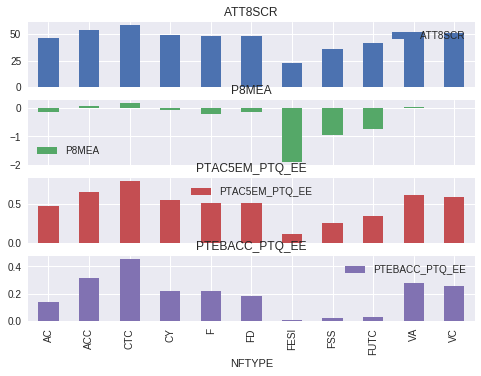

In [119]:
grouped_df.plot(kind='bar', subplots=True)

Interesting there appears to be something of a pattern emerging.

In [120]:
ks4_expanded_name['P8MEA']

'Progress 8 measure'

Let's tidy this plot up a little

In [121]:
grouped_df.index = [nftypes[code] for code in grouped_df.index]

In [122]:
grouped_df

,ATT8SCR,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
Sponsored academy,45.942857,-0.140321,0.471732,0.142161
Academy converter - mainstream,53.642727,0.094447,0.649485,0.315144
City technology college,58.433333,0.190000,0.793333,0.453333
Community school,49.399257,-0.058141,0.550409,0.216617
Free school - mainstream,48.285185,-0.193704,0.508519,0.217778
Foundation school,47.893818,-0.126291,0.513418,0.185236
Further Education Sector Institution,22.933333,-1.911667,0.115833,0.010833
Studio school,35.743333,-0.957000,0.255667,0.025000
UTC (university technical college),41.357692,-0.737308,0.345000,0.026538
Voluntary aided school,52.288645,0.055092,0.617436,0.279048


In [123]:
# make the percentages range from 0-100
grouped_df['PTAC5EM_PTQ_EE'] = grouped_df['PTAC5EM_PTQ_EE']*100
grouped_df['PTEBACC_PTQ_EE'] = grouped_df['PTEBACC_PTQ_EE']*100

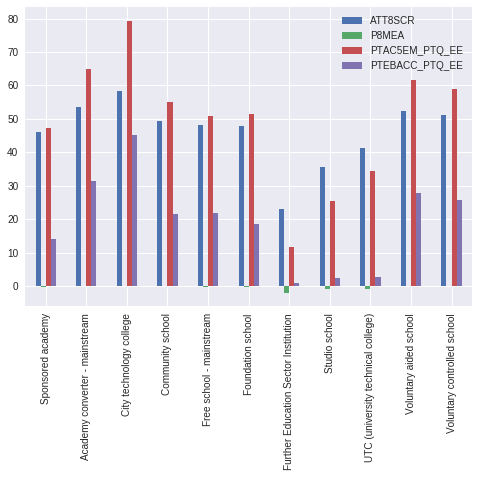

In [124]:
grouped_df.plot(kind='bar')

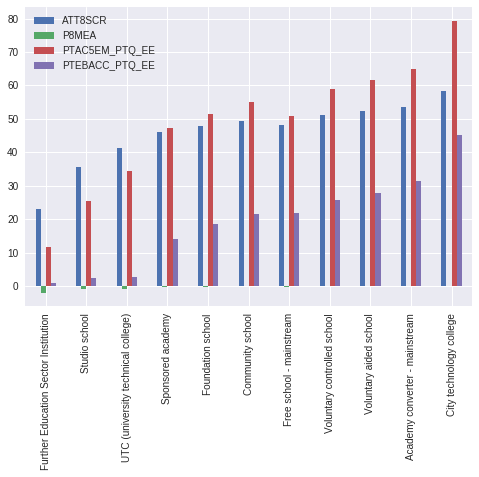

In [125]:
# let's try and sort the values
grouped_df.sort_values('PTEBACC_PTQ_EE').plot(kind='bar')

There does appear to be a relationship between school type and the results acheived. using the three most common measures.  In all cases the perc

In [126]:
ks4_expanded_name['ATT8SCR']

'Average Attainment 8 score per pupil'

I'm going to drop the attainment 8 score for now to get a clearer comparison of the schools

In [127]:
pct_df = grouped_df[['PTEBACC_PTQ_EE', 'PTAC5EM_PTQ_EE']].sort_values('PTEBACC_PTQ_EE')
pct_df

,PTEBACC_PTQ_EE,PTAC5EM_PTQ_EE
Further Education Sector Institution,1.083333,11.583333
Studio school,2.500000,25.566667
UTC (university technical college),2.653846,34.500000
Sponsored academy,14.216071,47.173214
Foundation school,18.523636,51.341818
Community school,21.661710,55.040892
Free school - mainstream,21.777778,50.851852
Voluntary controlled school,25.764706,59.000000
Voluntary aided school,27.904762,61.743590
Academy converter - mainstream,31.514394,64.948485


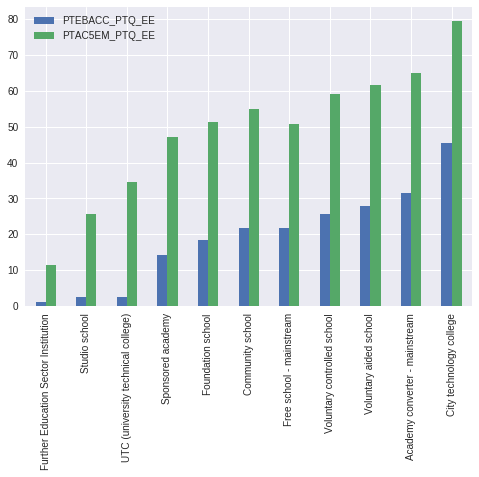

In [128]:
pct_df.plot(kind='bar')

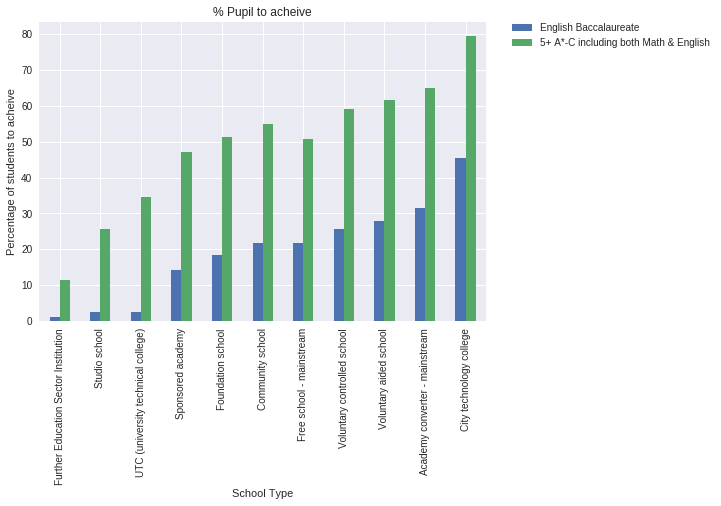

In [129]:
pct_df.plot(kind='bar')

# add the title and axis labels
plt.title('% Pupil to acheive')
plt.xlabel('School Type')
plt.ylabel('Percentage of students to acheive')


plt.legend(['English Baccalaureate',
          '5+ A*-C including both Math & English'],
          loc=(1.05, 0.9))

There does appear to be a some kind of link between the type of school and the results of both English Baccalaurete and the older 5+A*-C GCSEs.

The correlation between 5+A*-C and the EBacc makes sense because to acheive an eBacc is across a variety of subjects including Maths, English, Sciences, language and history or geography.  Naturally, there will be a correlation between the two.

Let's go back and look at the ATT8SC and the Progress 8 measures

In [130]:
p8_a8_df = grouped_df[['ATT8SCR', 'P8MEA']].sort_values('ATT8SCR')

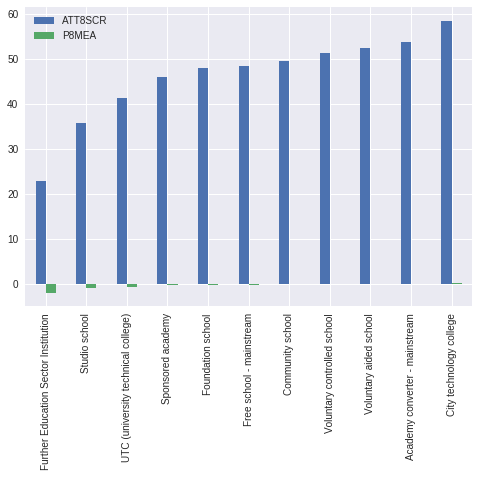

In [131]:
p8_a8_df.plot(kind='bar')

That isn't particularly clear as a plot.  I'll make subplots

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e2bc18550>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f7e2a078438>], dtype=object)

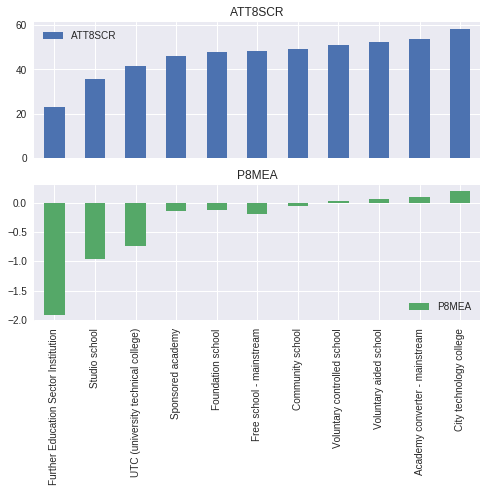

In [132]:
p8_a8_df.plot(kind='bar', subplots=True)

In [133]:
ks4_results_df.head()

,ATT8SCR,NFTYPE,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
2,50.1,CY,-0.26,0.53,0.30
3,60.1,VA,0.31,0.77,0.60
6,50.0,CY,0.09,0.52,0.33
7,47.0,CY,-0.11,0.47,0.09
8,57.6,VA,0.41,0.74,0.28


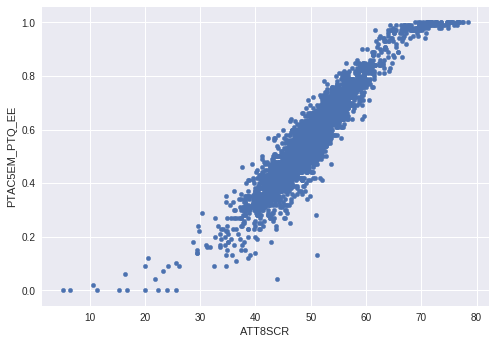

In [134]:
ks4_results_df.plot(kind='scatter', x='ATT8SCR', y='PTAC5EM_PTQ_EE')

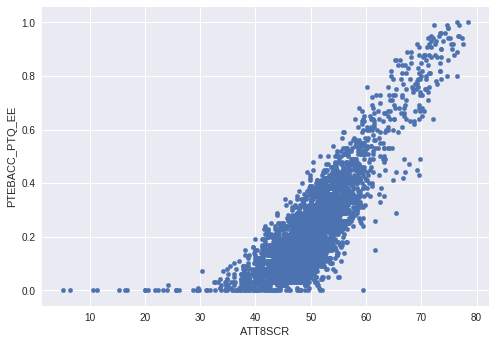

In [135]:
ks4_results_df.plot(kind='scatter', x='ATT8SCR', y='PTEBACC_PTQ_EE')

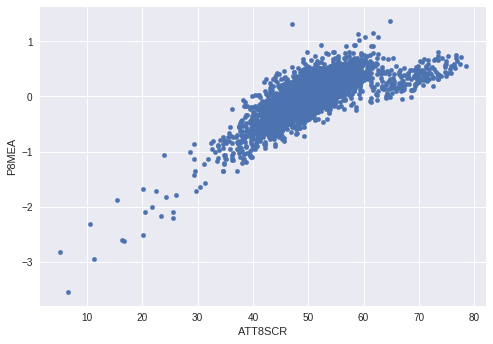

In [136]:
ks4_results_df.plot(kind='scatter', x='ATT8SCR', y='P8MEA')

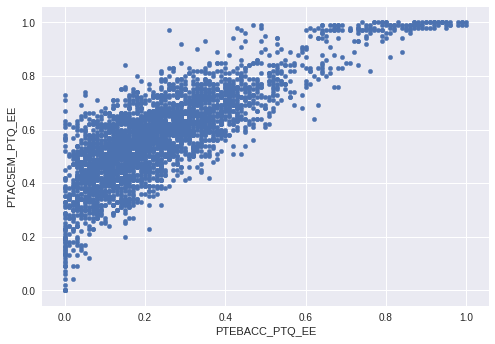

In [137]:
ks4_results_df.plot(kind='scatter', x='PTEBACC_PTQ_EE', y='PTAC5EM_PTQ_EE')

## Descriptive analysis

In [138]:
grouped_df.describe()

,ATT8SCR,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
count,11.000000,11.000000,11.000000,11.000000
mean,46.101300,-0.342022,49.189380,19.357597
std,9.790813,0.628671,19.090812,13.682365
min,22.933333,-1.911667,11.583333,1.083333
25%,43.650275,-0.465506,40.836607,8.434959
50%,48.285185,-0.126291,51.341818,21.661710
75%,51.741381,0.038869,60.371795,26.834734
max,58.433333,0.190000,79.333333,45.333333


In [139]:
ks4_full_results_df.describe()

,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
count,3974.000000,3974.000000
mean,0.515632,0.222584
std,0.256218,0.202560
min,0.000000,0.000000
25%,0.400000,0.070000
50%,0.550000,0.180000
75%,0.680000,0.320000
max,1.000000,1.000000


In [140]:
ks4_results_df.describe()

,ATT8SCR,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
count,3098.000000,3098.000000,3098.000000,3098.000000
mean,50.420013,-0.025691,0.575068,0.244296
std,7.482321,0.404514,0.173262,0.186333
min,5.100000,-3.540000,0.000000,0.000000
25%,46.000000,-0.230000,0.470000,0.110000
50%,50.100000,0.005000,0.570000,0.205000
75%,54.000000,0.240000,0.670000,0.330000
max,78.500000,1.370000,1.000000,1.000000


In [141]:
len(ks4_results_df[(ks4_results_df['PTAC5EM_PTQ_EE']==0)])

9

In [142]:
len(ks4_results_df[(ks4_results_df['PTEBACC_PTQ_EE']==0)])

74

These 0 values could be skewing the data.  Particularly if they were added by the `p2f` function.  However, there are only a small number of values.  I will calclulate the mean value of the column without them and replace the 0 with those and see whether it negatively impacts the results of the earlier findings.

In [143]:
ks4_results_df[(ks4_results_df['PTAC5EM_PTQ_EE']>0)]['PTAC5EM_PTQ_EE'].mean()

0.57674328261573327

A marginal increase for the 5 A*-C GCSE measure.

In [144]:
# changes values that are 0 to a given mean.
def set_to_mean(x, mean):
    if x == 0:
        return mean
    else:
        return x

In [145]:
ks4_results_df['PTAC5EM_PTQ_EE'] = ks4_results_df['PTAC5EM_PTQ_EE'].apply(lambda x: set_to_mean(x, 0.57674328261573327))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [146]:
# check that the mean is now correct
ks4_results_df['PTAC5EM_PTQ_EE'].mean()

0.57674328261573327

In [147]:
# calculate the proportional change in the mean value
(0.57674328261573327 / 0.575068 * 100) - 100

0.2913190467446043

A 0.29% increase in the mean value.

I'll do the same to the PTEBACC_PTQ_EE column.

In [148]:
ks4_results_df['PTEBACC_PTQ_EE'].mean()

0.2442963202065849

In [149]:
ks4_results_df[ks4_results_df['PTEBACC_PTQ_EE']>0]['PTEBACC_PTQ_EE'].mean()

0.25027447089947091

A 2.5% increase in the mean value. for the EBACC column.

In [150]:
ks4_results_df['PTEBACC_PTQ_EE'] = ks4_results_df['PTEBACC_PTQ_EE'].apply(lambda x: set_to_mean(x, 0.25027447089947091))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [151]:
ks4_results_df['PTEBACC_PTQ_EE'].mean()

0.25027447089947091

In [152]:
# calculate the proportional change in the mean value
(0.25027447089947091 / 0.2442963202065849 * 100) - 100

2.4470899470899496

While still quite small in comparison to the 5+A*-C measure this is a proportionally larger increase in the mean value.

Let's plot the data again to see whether the findings have been impacted.

In [153]:
#  Group the data again to visualise
grouped_res = ks4_results_df[['NFTYPE', 'ATT8SCR', 'P8MEA', 'PTAC5EM_PTQ_EE', 'PTEBACC_PTQ_EE']].groupby(by='NFTYPE').mean()
grouped_df = pd.DataFrame(grouped_res)
grouped_df

,ATT8SCR,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
NFTYPE,,,,
AC,45.942857,-0.140321,0.471732,0.147971
ACC,53.642727,0.094447,0.649485,0.315713
CTC,58.433333,0.190000,0.793333,0.453333
CY,49.399257,-0.058141,0.550409,0.219408
F,48.285185,-0.193704,0.529879,0.245586
FD,47.893818,-0.126291,0.513418,0.187967
FESI,22.933333,-1.911667,0.356143,0.177683
FSS,35.743333,-0.957000,0.274891,0.208535
FUTC,41.357692,-0.737308,0.389365,0.161302


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e30db9eb8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f7e22c35240>], dtype=object)

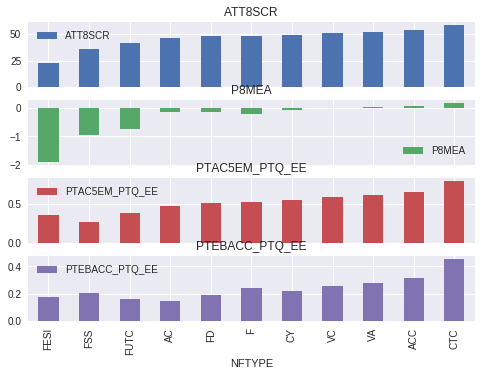

In [154]:
grouped_df.sort_values('ATT8SCR').plot(kind='bar', subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e2bc47f98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f7e2bbcd908>], dtype=object)

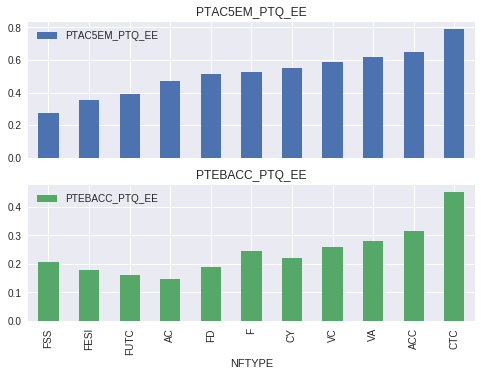

In [155]:
grouped_df[['PTAC5EM_PTQ_EE', 'PTEBACC_PTQ_EE']].sort_values('PTAC5EM_PTQ_EE').plot(kind='bar', subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e2bb43d30>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f7e2ba4f1d0>], dtype=object)

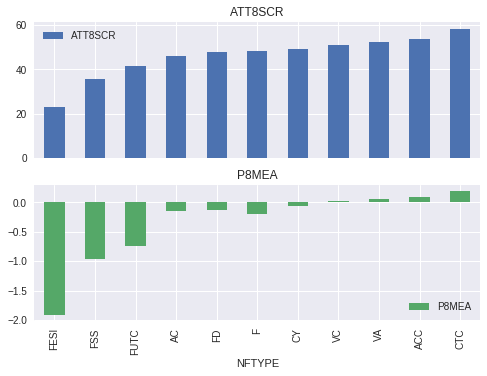

In [156]:
grouped_df[['ATT8SCR', 'P8MEA']].sort_values('ATT8SCR').plot(kind='bar', subplots=True)

# Visualisations

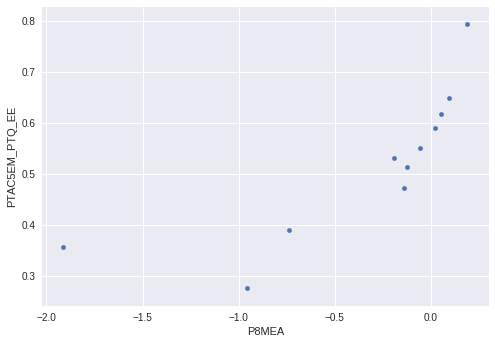

In [157]:
grouped_df.plot(kind='scatter', x='P8MEA', y='PTAC5EM_PTQ_EE')

# Cluster analysis

In [158]:
# make a dataframe for just these two measures
p8_ac_df = grouped_df[['P8MEA', 'PTAC5EM_PTQ_EE']]
p8_ac_df

,P8MEA,PTAC5EM_PTQ_EE
NFTYPE,,
AC,-0.140321,0.471732
ACC,0.094447,0.649485
CTC,0.190000,0.793333
CY,-0.058141,0.550409
F,-0.193704,0.529879
FD,-0.126291,0.513418
FESI,-1.911667,0.356143
FSS,-0.957000,0.274891
FUTC,-0.737308,0.389365


### initial values for k = 2


In [159]:
initialCentroids_df = pd.DataFrame({'P8MEA': [-1.5, 0], 
                                    'PTAC5EM_PTQ_EE': [0.4, 0.5]}, 
                                   columns=['P8MEA', 'PTAC5EM_PTQ_EE'])

initialCentroids_df

,P8MEA,PTAC5EM_PTQ_EE
0,-1.5,0.4
1,0.0,0.5


and plot these on a scatter plot with the data points:

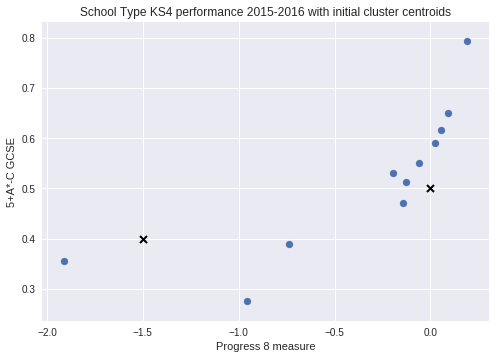

In [160]:
plt.scatter(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'])

plt.xlabel('Progress 8 measure')
plt.ylabel('5+A*-C GCSE')

plt.title('School Type KS4 performance 2015-2016 with initial cluster centroids')

# Plot the initial centroids:
for i in initialCentroids_df.index:
    plt.plot(initialCentroids_df.iloc[i]['P8MEA'],
             initialCentroids_df.iloc[i]['PTAC5EM_PTQ_EE'],
             color='black', marker='x', mew=2)

In [161]:
# initialise the clustering object
kmeans2 = cluster.KMeans(n_clusters=2,
                         init=initialCentroids_df)

In [162]:
# fit the object to the data
assignedClusters_clust = kmeans2.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assignedClusters_clust.labels_

/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1], dtype=int32)

... and plot the clustered data along with the final centroids:

[]

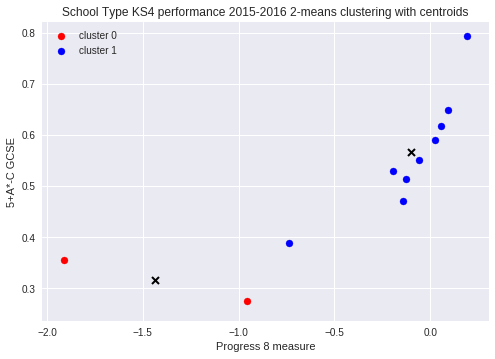

In [163]:
# Plot the data points which is in the cluster labelled '0'
plt.scatter(p8_ac_df['P8MEA'][assignedClusters_clust.labels_==0],
            p8_ac_df['PTAC5EM_PTQ_EE'][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which is in the cluster labelled '1'
plt.scatter(p8_ac_df['P8MEA'][assignedClusters_clust.labels_==1],
            p8_ac_df['PTAC5EM_PTQ_EE'][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# plot each of the centroids:
for (cx, cy) in assignedClusters_clust.cluster_centers_:
    plt.plot(cx, cy, color='black', marker='x', mew=2)
    
plt.legend()

plt.xlabel('Progress 8 measure')
plt.ylabel('5+A*-C GCSE')

plt.title('School Type KS4 performance 2015-2016 2-means clustering with centroids')

plt.plot()


## Lets try k=4

In [164]:
import random
# set the seed so that analysis is consitent on each run.
random.seed(283)

In [165]:
# helper function to quickly generate a dataframe 
# of a given number of random centroids
def random_centroids(x_range, y_range, num_centroids):
    centroids = collections.defaultdict(list)
    for i in range(num_centroids):
        centroids['A'].append(random.uniform(min(x_range), max(x_range)))
        centroids['B'].append(random.uniform(min(y_range), max(y_range)))
    
    return pd.DataFrame(centroids)

# generate 3 different sets of centroids
initialCentroids_a = random_centroids([-2,0.25], [0.2, 0.9], 4)
initialCentroids_b = random_centroids([-2,0.25], [0.2, 0.9], 4)
initialCentroids_c = random_centroids([-2,0.25], [0.2, 0.9], 4)


In [166]:
initialCentroids_a

,A,B
0,-0.369014,0.295589
1,-0.810761,0.384093
2,-0.101376,0.870578
3,-0.589770,0.503782


In [167]:
initialCentroids_b

,A,B
0,-0.418850,0.302404
1,0.188490,0.335646
2,-0.304231,0.592356
3,-1.595133,0.840760


In [168]:
initialCentroids_c

,A,B
0,-1.043376,0.533182
1,-1.305089,0.459466
2,-1.565558,0.462669
3,0.163845,0.337914


In [169]:
# create 3 corresponding k-means clusters
kmeans4_a = cluster.KMeans(n_clusters=4, init=initialCentroids_a)
kmeans4_b = cluster.KMeans(n_clusters=4, init=initialCentroids_b)
kmeans4_c = cluster.KMeans(n_clusters=4, init=initialCentroids_c)

In [170]:
# fit the cluster object to the data
assignedClusters_clust_a = kmeans4_a.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assignedClusters_clust_b = kmeans4_b.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assignedClusters_clust_c = kmeans4_c.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])

/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [171]:
# Helper function to plot clustering results, 
# colors do not need to be set unless num is greater than 6
def plot_cluster(data_x, data_y, assigned_clust, num, 
                 cluster_labels=None, plt_labels=None, 
                 plt_title=None, colors=None):
    # set default colors
    if colors==None:
        colors = sns.palettes.color_palette(n_colors=num)
    # set default labels
    if cluster_labels==None:
        cluster_labels = range(num)
    # plot the cluster group    
    for c in range(num):
        plt.scatter(data_x[assigned_clust.labels_==c],
                    data_y[assigned_clust.labels_==c],
                    color=colors[c], marker='o', label=cluster_labels[c]
                   )
    
    for (cx, cy) in assigned_clust.cluster_centers_:
        plt.plot(cx, cy, color='black', marker='x', mew=2)
    
    plt.legend()
        
    plt.xlabel(plt_labels[0])
    plt.ylabel(plt_labels[1])
        
    plt.title(plt_title)


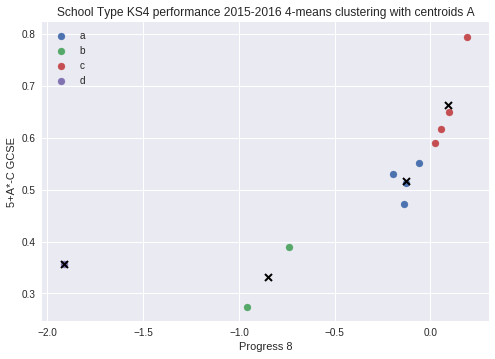

In [172]:
# plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], assignedClusters_clust_a, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016 4-means clustering with centroids A')

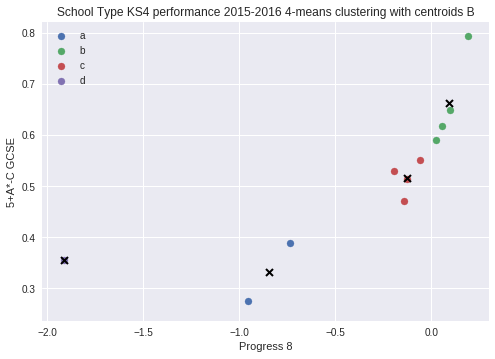

In [173]:
# plot the second trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], assignedClusters_clust_b, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016 4-means clustering with centroids B')

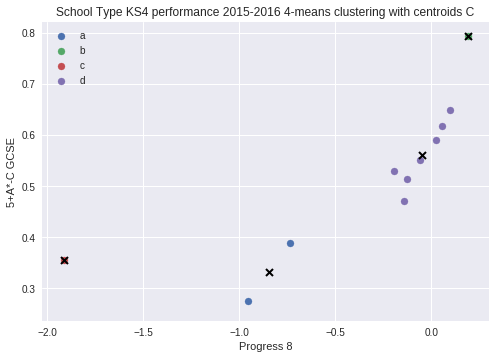

In [174]:
# Plot the third trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], assignedClusters_clust_c, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016 4-means clustering with centroids C')

Let's try some other values of k

### K = 5

In [175]:
#  generate 3 sets of random centroids
init_centroids_5a = random_centroids([-2, 0.25], [0.2,0.85], 5)
init_centroids_5b = random_centroids([-2, 0.25], [0.2,0.85], 5)
init_centroids_5c = random_centroids([-2, 0.25], [0.2,0.85], 5)

In [176]:
# create 3 corresponding k-means clusters
kmeans5_a = cluster.KMeans(n_clusters=5, init=init_centroids_5a)
kmeans5_b = cluster.KMeans(n_clusters=5, init=init_centroids_5b)
kmeans5_c = cluster.KMeans(n_clusters=5, init=init_centroids_5c)

In [177]:
# fit the object to the data
assigned_clust_a = kmeans5_a.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_b = kmeans5_b.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_c = kmeans5_c.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])


/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


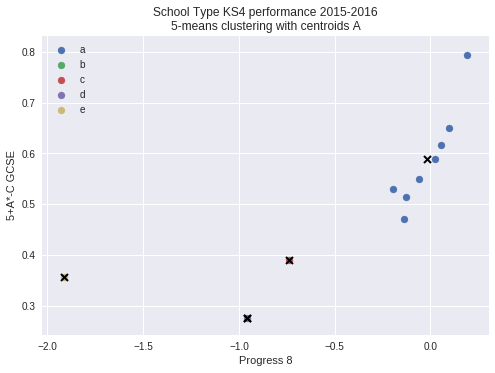

In [178]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], assigned_clust_a, 5,
             cluster_labels=['a', 'b', 'c', 'd', 'e'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n5-means clustering with centroids A')

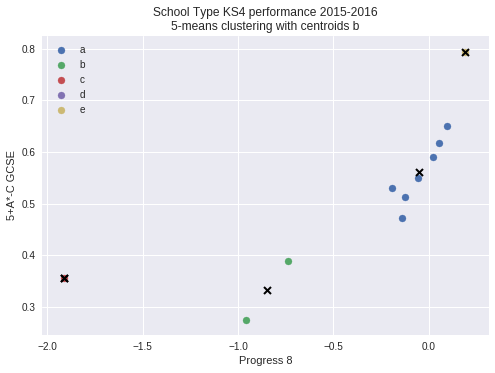

In [179]:
# Plot the second trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_b, 5,
             cluster_labels=['a', 'b', 'c', 'd', 'e'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n5-means clustering with centroids b')

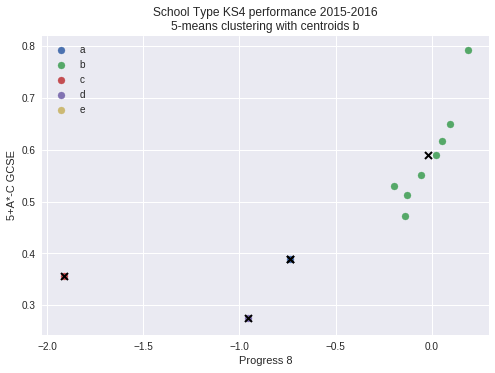

In [180]:
# Plot the third trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_c, 5,
             cluster_labels=['a', 'b', 'c', 'd', 'e'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n5-means clustering with centroids b')

# k = 6

In [181]:
#  generate 3 sets of random centroids
init_centroids_a = random_centroids([-2, 0.25], [0.2,0.85], 6)
init_centroids_b = random_centroids([-2, 0.25], [0.2,0.85], 6)
init_centroids_c = random_centroids([-2, 0.25], [0.2,0.85], 6)

In [182]:
# create 3 corresponding k-means clusters
kmeans6_a = cluster.KMeans(n_clusters=6, init=init_centroids_a)
kmeans6_b = cluster.KMeans(n_clusters=6, init=init_centroids_b)
kmeans6_c = cluster.KMeans(n_clusters=6, init=init_centroids_c)

In [183]:
# fit the object to the data
assigned_clust_a = kmeans6_a.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_b = kmeans6_b.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_c = kmeans6_c.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])



/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


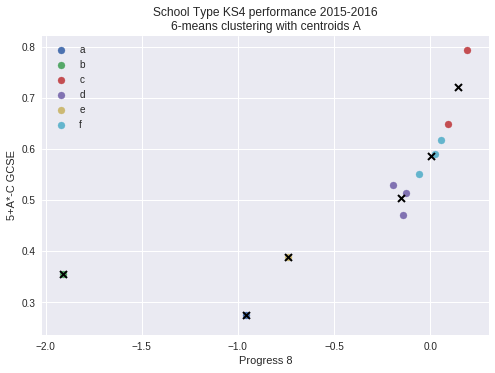

In [184]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_a, 6,
             cluster_labels=['a', 'b', 'c', 'd', 'e', 'f'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n6-means clustering with centroids A')

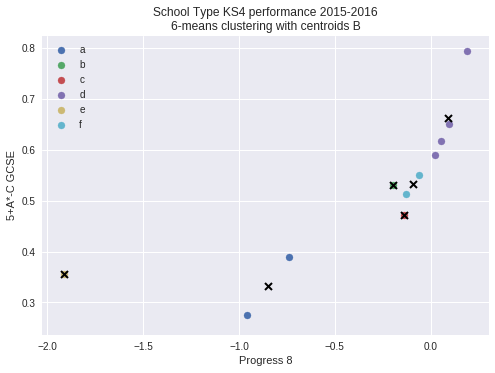

In [185]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_b, 6,
             cluster_labels=['a', 'b', 'c', 'd', 'e', 'f'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n6-means clustering with centroids B')

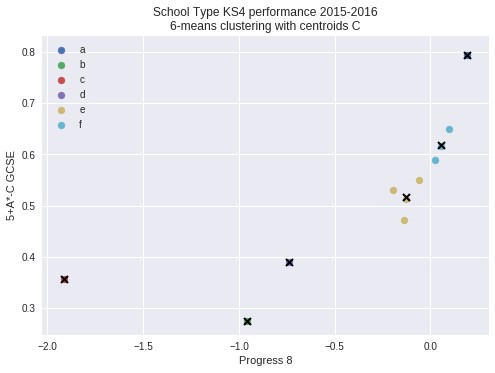

In [186]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_c, 6,
             cluster_labels=['a', 'b', 'c', 'd', 'e', 'f'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n6-means clustering with centroids C')

These clusterings show that the higher the k-value gets the less stable the results are.  k=4 seems to give the most consistent groupings for randomly initialised centroids.

I'll quickly do 5 trials of k=4 to see if they stay consistent.

In [187]:
#  generate 3 sets of random centroids
init_centroids_4a = random_centroids([-2, 0.25], [0.2,0.85], 4)
init_centroids_4b = random_centroids([-2, 0.25], [0.2,0.85], 4)
init_centroids_4c = random_centroids([-2, 0.25], [0.2,0.85], 4)
init_centroids_4d = random_centroids([-2, 0.25], [0.2,0.85], 4)
init_centroids_4e = random_centroids([-2, 0.25], [0.2,0.85], 4)

In [188]:
# create 3 corresponding k-means clusters
kmeans4_a = cluster.KMeans(n_clusters=4, init=init_centroids_4a)
kmeans4_b = cluster.KMeans(n_clusters=4, init=init_centroids_4b)
kmeans4_c = cluster.KMeans(n_clusters=4, init=init_centroids_4c)
kmeans4_d = cluster.KMeans(n_clusters=4, init=init_centroids_4d)
kmeans4_e = cluster.KMeans(n_clusters=4, init=init_centroids_4e)

In [189]:
# fit the object to the data
assigned_clust_a = kmeans4_a.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_b = kmeans4_b.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_c = kmeans4_c.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_d = kmeans4_d.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_e = kmeans4_e.fit(p8_ac_df[['P8MEA', 'PTAC5EM_PTQ_EE']])



/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


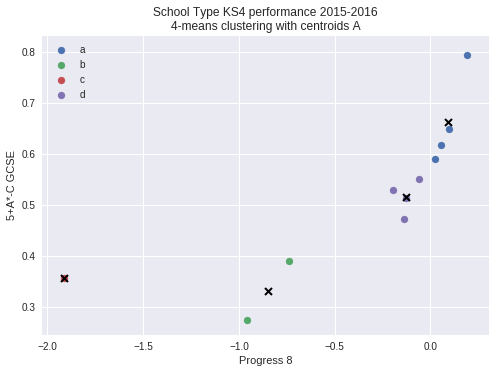

In [190]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_a, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n4-means clustering with centroids A')

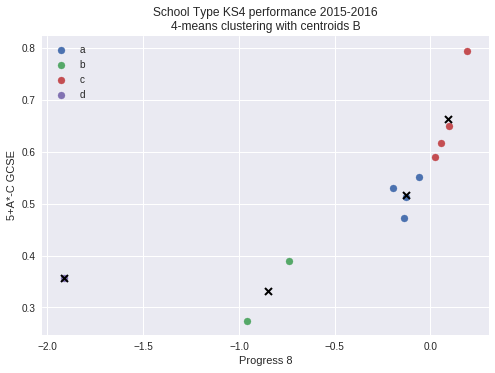

In [191]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_b, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n4-means clustering with centroids B')

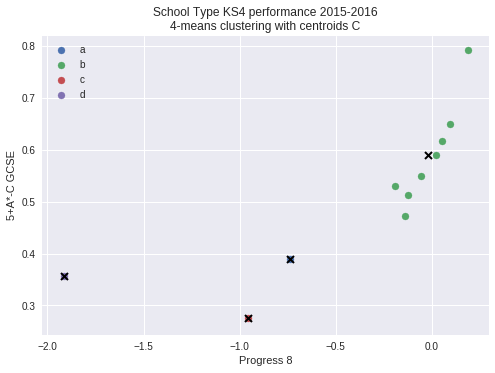

In [192]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_c, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n4-means clustering with centroids C')

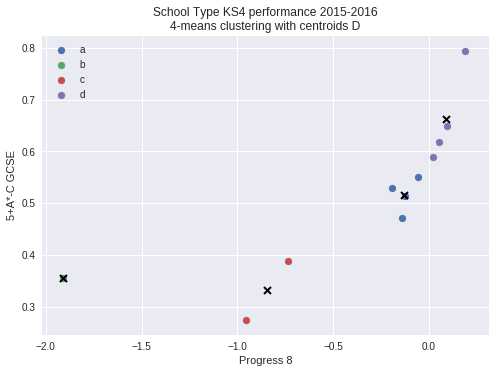

In [193]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_d, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n4-means clustering with centroids D')

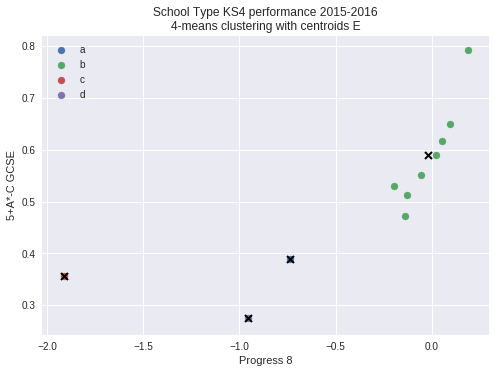

In [194]:
# Plot the first trial
plot_cluster(p8_ac_df['P8MEA'], p8_ac_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_e, 4,
             cluster_labels=['a', 'b', 'c', 'd'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n4-means clustering with centroids E')

There are clearly a few ways that this dataset can be clustered.  It is perhaps worth noting that the most of the school types are around the national average measure for Progress8 (0), and above 50% for the GCSE measure.  Their are two clear outliers one at the top right (best score for both GCSE, and progress8) and one at the bottom (second worse GCSE and by far the worse progress8), let's identify which school types they are.

In [195]:
nftypes[p8_ac_df['P8MEA'].idxmax()]

'City technology college'

In [196]:
nftypes[p8_ac_df['P8MEA'].idxmin()]

'Further Education Sector Institution'

In [197]:
nftypes[p8_ac_df['PTAC5EM_PTQ_EE'].idxmax()]

'City technology college'

In [198]:
nftypes[p8_ac_df['PTAC5EM_PTQ_EE'].idxmin()]

'Studio school'

In [199]:
ks4_results_df[ks4_results_df['NFTYPE']=='CTC'].count()

ATT8SCR           3
NFTYPE            3
P8MEA             3
PTAC5EM_PTQ_EE    3
PTEBACC_PTQ_EE    3
dtype: int64

In [200]:
ks4_results_df[ks4_results_df['NFTYPE']=='FSS'].count()

ATT8SCR           30
NFTYPE            30
P8MEA             30
PTAC5EM_PTQ_EE    30
PTEBACC_PTQ_EE    30
dtype: int64

In [201]:
ks4_results_df[ks4_results_df['NFTYPE']=='FESI'].count()

ATT8SCR           12
NFTYPE            12
P8MEA             12
PTAC5EM_PTQ_EE    12
PTEBACC_PTQ_EE    12
dtype: int64

In [202]:
nftypes

{'AC': 'Sponsored academy',
 'AC1619': 'Academy 16-19 sponsor led',
 'ACC': 'Academy converter - mainstream',
 'ACC1619': 'Academy 16-19 converter',
 'ACCS': 'Academy converter - special school',
 'ACS': 'Sponsored special academy',
 'CTC': 'City technology college',
 'CY': 'Community school',
 'CYS': 'Community special school',
 'F': 'Free school - mainstream',
 'F1619': 'Free school - 16-19',
 'FD': 'Foundation school',
 'FDS': 'Foundation special school',
 'FESI': 'Further Education Sector Institution',
 'FS': 'Free school - special',
 'FSS': 'Studio school',
 'FUTC': 'UTC (university technical college)',
 'IND': 'Independent school',
 'INDSPEC': 'Independent special school',
 'MODFC': 'College funded by Ministry of Defence',
 'NMSS': 'Non-maintained special school',
 'VA': 'Voluntary aided school',
 'VC': 'Voluntary controlled school'}

In [203]:
ks4_results_df.head()

,ATT8SCR,NFTYPE,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
2,50.1,CY,-0.26,0.53,0.30
3,60.1,VA,0.31,0.77,0.60
6,50.0,CY,0.09,0.52,0.33
7,47.0,CY,-0.11,0.47,0.09
8,57.6,VA,0.41,0.74,0.28


In [226]:
# Top performing schools for each column
for c in grouped_df.columns:
    top = grouped_df[c].idxmax()
    bottom = grouped_df[c].idxmin()
    
    print(c, ':\nTop performer:', nftypes[top], 
          '\nBottom performer:', nftypes[bottom],'\n')

ATT8SCR :
Top performer: City technology college 
Bottom performer: Further Education Sector Institution 

P8MEA :
Top performer: City technology college 
Bottom performer: Further Education Sector Institution 

PTAC5EM_PTQ_EE :
Top performer: City technology college 
Bottom performer: Studio school 

PTEBACC_PTQ_EE :
Top performer: City technology college 
Bottom performer: Sponsored academy 



<a name="machine_learning"></a>

# Machine Learning

## k-means cluster analysis of the ungrouped dataset.

In [227]:
ks4_results_df.head()

,ATT8SCR,NFTYPE,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
2,50.1,CY,-0.26,0.53,0.30
3,60.1,VA,0.31,0.77,0.60
6,50.0,CY,0.09,0.52,0.33
7,47.0,CY,-0.11,0.47,0.09
8,57.6,VA,0.41,0.74,0.28


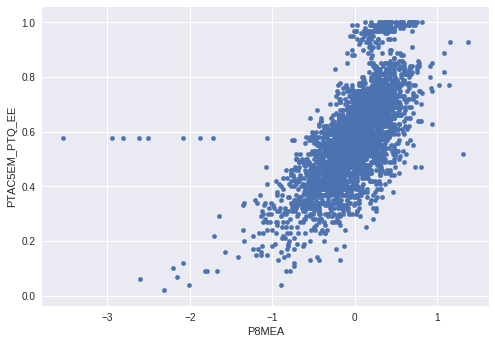

In [228]:
ks4_results_df.plot(kind='scatter', x='P8MEA', y='PTAC5EM_PTQ_EE')

To run a kmeans cluster analysis on the whole dataset I will first determine the x_range, and y_range to feed into the random centroid generator.  I can use the dataframe itself for this.

In [229]:
# determine the ranges of the data
x_range = [min(ks4_results_df['P8MEA']), max(ks4_results_df['P8MEA'])]
y_range = [min(ks4_results_df['PTAC5EM_PTQ_EE']), max(ks4_results_df['PTAC5EM_PTQ_EE'])]

In [208]:
# generate sets of random centroids for different k values
init_centroids_3 = random_centroids(x_range, y_range, 3)
init_centroids_4 = random_centroids(x_range, y_range, 4)
init_centroids_5 = random_centroids(x_range, y_range, 5)
init_centroids_6 = random_centroids(x_range, y_range, 6)

In [209]:
# create corresponding k-means clusters
kmeans_3 = cluster.KMeans(n_clusters=3, init=init_centroids_3)
kmeans_4 = cluster.KMeans(n_clusters=4, init=init_centroids_4)
kmeans_5 = cluster.KMeans(n_clusters=5, init=init_centroids_5)
kmeans_6 = cluster.KMeans(n_clusters=6, init=init_centroids_6)

In [235]:
# fit the object to the data
assigned_clust_3 = kmeans_3.fit(ks4_results_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_4 = kmeans_4.fit(ks4_results_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_5 = kmeans_5.fit(ks4_results_df[['P8MEA', 'PTAC5EM_PTQ_EE']])
assigned_clust_6 = kmeans_6.fit(ks4_results_df[['P8MEA', 'PTAC5EM_PTQ_EE']])

/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


### kMeans 3 clustering

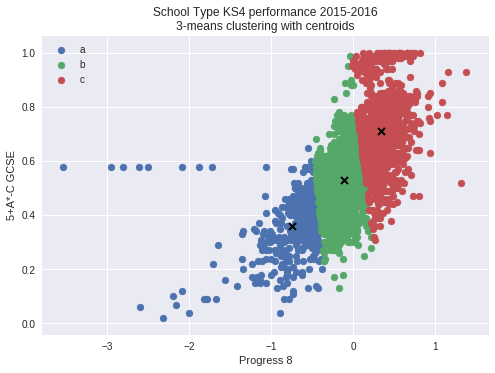

In [236]:
# Plot kMeans 3
plot_cluster(ks4_results_df['P8MEA'], ks4_results_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_3, 3,
             cluster_labels=['a', 'b', 'c'],
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n3-means clustering with centroids')

### kMeans 4 clustering

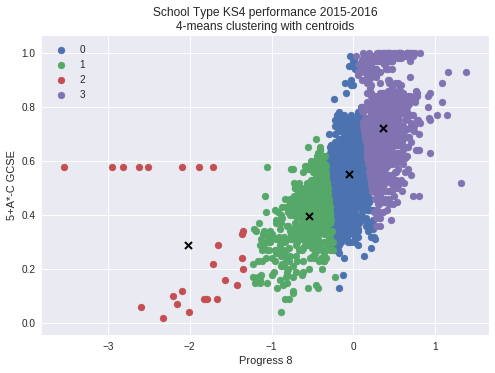

In [237]:
# Plot the k-means = 4
plot_cluster(ks4_results_df['P8MEA'], ks4_results_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_4, 4,
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n4-means clustering with centroids')

### kMeans 5 clustering

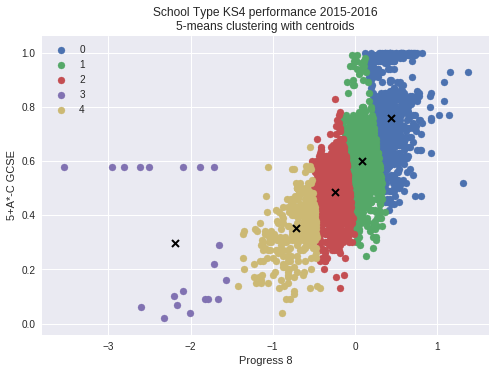

In [233]:
# Plot the k-means = 5
plot_cluster(ks4_results_df['P8MEA'], ks4_results_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_5, 5,
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n5-means clustering with centroids')

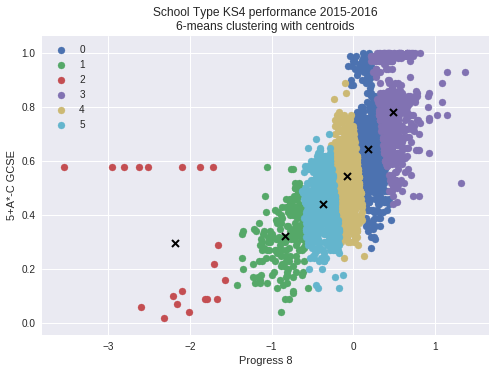

In [234]:
# Plot the k-means = 6
plot_cluster(ks4_results_df['P8MEA'], ks4_results_df['PTAC5EM_PTQ_EE'], 
             assigned_clust_6, 6,
             plt_labels=['Progress 8', '5+A*-C GCSE'],
             plt_title='School Type KS4 performance 2015-2016\n6-means clustering with centroids')

In [216]:
# kmeans = 5 gives us a reasonable spead of clusters
a_df = ks4_results_df[assigned_clust_5.labels_==0]
b_df = ks4_results_df[assigned_clust_5.labels_==1]
c_df = ks4_results_df[assigned_clust_5.labels_==2]
d_df = ks4_results_df[assigned_clust_5.labels_==3]
e_df = ks4_results_df[assigned_clust_5.labels_==4]

In [217]:
a_df['NFTYPE'].count()

707

In [218]:
a_df['NFTYPE'].value_counts()

ACC    420
CY      85
AC      81
VA      76
FD      32
F        5
VC       5
CTC      2
FSS      1
Name: NFTYPE, dtype: int64

In [219]:
a_df.groupby(by='NFTYPE').mean().sort_values('ATT8SCR')

,ATT8SCR,P8MEA,PTAC5EM_PTQ_EE,PTEBACC_PTQ_EE
NFTYPE,,,,
AC,53.069136,0.506914,0.652716,0.272599
F,54.900000,0.584000,0.648000,0.368000
FSS,55.200000,0.220000,0.810000,0.240000
CY,55.323529,0.414941,0.686941,0.348235
FD,56.121875,0.394375,0.701875,0.350625
VC,56.760000,0.480000,0.698000,0.448000
VA,58.706579,0.483026,0.757763,0.434609
ACC,60.540952,0.415643,0.802048,0.493024
CTC,62.200000,0.455000,0.915000,0.560000


#  Q2 - Keystage 2 and 4 Investigation.  Do schools that perform well at KS2 deliver as good or better results at KS4.
<a name="q2"></a>

The first thing I need to decide before I can analyse the data is to decide what I mean by 'good performance' and which measures I will use to compare

### Descriptive analysis

### Choosing the measures I will use to compare the schools

### What flaws are there in the data/subset of data that could impact findings

### Carry out some analysis resulting in a few plots that convey findings

### Run some statistical tests

### Summarise findings

<a name="machine_learning"></a>

# Machine Learning.

Two main chances to implement it as I see it.
- it can be used to fill in missing values
- it can be used to predict what a schools results will be at ks4
- it could be used to cluster groups.

# Cleanup/remove the database
<a name="cleanup"></a>

Uncomment the lines below to remove the MongoDB created in the investigation.

In [220]:
# uncomment to remove the database if needed
client.drop_database('schools_db')
client.database_names()

['accidents', 'admin', 'local']